this copy includes the feature, Last _ major _ derog _ none - 1 (when the loaner has a bad rating for at least 90 days), which was removed at first due to havingn large amount of missing values.

idea: The dataset may contain wrong labels. A solution is detect anomalies in the dataset using Gaussian Mixture, and then inspect the anomaly data points

In [9]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
from sklearn.semi_supervised import LabelPropagation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import auc, roc_curve, make_scorer, log_loss, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
from glob import glob
glob('./*')

['./Predict_bad_loan.ipynb',
 './Loan_Dataset_3.csv',
 './Loan_Dataset.csv',
 './Predict_bad_loan_cont_(Unsupervised_&_Supervised_approach).ipynb',
 './Loan_Dataset_2.csv',
 './project_slides.pdf',
 './Predict_bad_loan_cont_Anomaly_Detection_questionable_data?-Copy1.ipynb',
 './bad_data.csv',
 './Predict_bad_loan_cont_Anomaly_Detection_final_notebook-Copy1.ipynb',
 './df_after_cleaning',
 './Predict_bad_loan_cont_(Dimensionality_Reduction_approach).ipynb',
 './Predict_bad_loan_cont_Anomaly_Detection_questionable_data?.ipynb',
 './df_cleaned.csv',
 './Predict_bad_loan_cont_Anomaly_Detection_good_data?-Copy1.ipynb',
 './Predict_bad_loan_cont_Anomaly_Detection_final_notebook.ipynb',
 './df_after_cleaning.csv',
 './Predict_bad_loan_cont_Anomaly_Detection_disregard.ipynb',
 './variable_descriptions',
 './Predict_bad_loan_cont_Anomaly_Detection_good_data?.ipynb',
 './good_data.csv']

In [12]:
df_ori = pd.read_csv('df_cleaned.csv')
df_ori

id grade  annual_income  short_employee  emp_length_num  \
0      11454641     A         100000               1               1   
1       9604874     A          83000               0               4   
2       9684700     D          78000               0              11   
3       9695736     D          37536               0               6   
4       9795013     D          65000               0              11   
...         ...   ...            ...             ...             ...   
18365   6595657     B          27000               0               9   
18366   1576331     B          45000               0               2   
18367   6645736     B         104000               0               5   
18368   6625736     A          38400               0               2   
18369   6625685     B         150000               0              11   

      home_ownership  Debt-To-Income Ratio             purpose       term  \
0               RENT                 26.27         credit_card  36 months   
1                OWN                  5.39         credit_card  36 months   
2           MORTGAGE                 18.45  debt_consolidation  60 months   
3           MORTGAGE                 12.28             medical  60 months   
4           MORTGAGE                 11.26  debt_consolidation  36 months   
...              ...                   ...                 ...        ...   
18365           RENT                 18.36  debt_consolidation  36 months   
18366       MORTGAGE                 23.22      major_purchase  36 months   
18367       MORTGAGE                 13.27  debt_consolidation  36 months   
18368       MORTGAGE                 12.84  debt_consolidation  36 months   
18369       MORTGAGE                  2.20         credit_card  36 months   

       last_delinq_none last_major_derog_none  revol_util  total_rec_late_fee  \
0                     1               missing        43.2                 0.0   
1                     0               missing        21.5                 0.0   
2                     1               missing        46.3                 0.0   
3                     0               missing        10.7                 0.0   
4                     0               missing        15.2                 0.0   
...                 ...                   ...         ...                 ...   
18365                 1               missing        46.5                 0.0   
18366                 0               missing        46.2                 0.0   
18367                 1               missing        78.5                 0.0   
18368                 0               missing        47.4                 0.0   
18369                 0               missing        40.7                 0.0   

       od_ratio  bad_loan  
0      0.160624         0  
1      0.810777         0  
2      0.035147         1  
3      0.534887         1  
4      0.166500         0  
...         ...       ...  
18365  0.821782         1  
18366  0.652200         0  
18367  0.482555         0  
18368  0.822980         0  
18369  0.201388         0  

[18370 rows x 15 columns]

In [13]:
df_good = pd.read_csv('good_data.csv')
df_bad = pd.read_csv('bad_data.csv')

In [14]:
df_bad.columns

Index(['id', 'annual_income', 'short_employee', 'emp_length_num',
       'Debt-To-Income Ratio', 'revol_util', 'total_rec_late_fee', 'od_ratio',
       'bad_loan', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_36 months',
       'term_60 months', 'last_delinq_none_0', 'last_delinq_none_1',
       'last_major_derog_none_0.0', 'last_major_derog_none_1.0',
       'last_major_derog_none_missing', 'annual_income_log'],
      dtype='object')

In [15]:
def get_metrics(target_test, target_score, target_pred):
    precision, recall, thresholds = precision_recall_curve(target_test, target_score)
    fpr, tpr, thresholds = roc_curve(target_test, target_score)
    pr_auc = average_precision_score(target_test, target_score)
    roc_auc = auc(fpr, tpr)
    accuracy = accuracy_score(target_test, target_pred)
    
    print(f'PR AUC is {pr_auc:.2f}. ROC AUC is {roc_auc:.2f}, Accuracy is {accuracy:.2f}')
    return precision, recall, pr_auc, fpr, tpr, roc_auc

def get_confusion_matrix(target_test, target_pred):
    matrix = confusion_matrix(target_test, target_pred)
    df = pd.DataFrame(matrix, index=['Actual Negative', 'Actual Positive'], 
                 columns=['Predicted Negative', 'Predicted Positive'])
    return df

In [16]:
# X_good = df_good.drop(columns=['bad_loan'])
# y_good = df_good.bad_loan

# num_to_sample = X_good.shape[0]

# X_bad = df_bad.drop(columns=['bad_loan']).iloc[:num_to_sample]
# y_bad = pd.Series([-1]*num_to_sample)

In [17]:
# X_joined = pd.concat([X_good,X_bad])
# y_joined = pd.concat([y_good,y_bad])

In [18]:
# label_prop_model = LabelPropagation(n_neighbors=5,n_jobs=-1)
# label_prop_model.fit(X_joined, y_joined)
# X_bad_label = label_prop_model.predict(X_bad)
# X_bad_label.mean()

In [19]:
#use cosine similarity to compare similarity between good data with label 1 and bad data with label 0

df_joined = pd.concat([df_good, df_bad])
df_joined.reset_index(inplace=True, drop=True)
df_joined.sort_index()

id  annual_income  short_employee  emp_length_num  \
0      10166062          70000               0               7   
1      10117251         158000               0               2   
2      10167775          52000               0              11   
3      10147584          18500               1               1   
4      10098413          41600               0               3   
...         ...            ...             ...             ...   
18365   6645248          60000               0              11   
18366   6554577          93000               0              11   
18367   6624630          35000               0               2   
18368   6533295          31500               0               4   
18369   6595657          27000               0               9   

       Debt-To-Income Ratio  revol_util  total_rec_late_fee  od_ratio  \
0                     13.85        61.2                 0.0  0.324621   
1                      0.23        25.5                 0.0  0.552883   
2                     21.21        87.4                 0.0  0.042664   
3                      2.92         6.7                 0.0  0.212812   
4                     17.22        73.9                 0.0  0.755054   
...                     ...         ...                 ...       ...   
18365                  4.58        22.2                 0.0  0.089992   
18366                 17.41        89.0                 0.0  0.338595   
18367                 21.70        67.0                 0.0  0.782253   
18368                 10.25        87.3                 0.0  0.799392   
18369                 18.36        46.5                 0.0  0.821782   

       bad_loan  grade_A  grade_B  grade_C  grade_D  grade_E  grade_F  \
0             0        0        0        0        0        0        1   
1             0        0        0        1        0        0        0   
2             0        0        0        0        0        0        1   
3             0        0        0        0        0        0        1   
4             0        0        1        0        0        0        0   
...         ...      ...      ...      ...      ...      ...      ...   
18365         1        0        0        1        0        0        0   
18366         1        0        0        0        1        0        0   
18367         1        0        0        1        0        0        0   
18368         1        0        0        0        1        0        0   
18369         1        0        1        0        0        0        0   

       grade_G  home_ownership_MORTGAGE  home_ownership_OWN  \
0            0                        1                   0   
1            0                        0                   1   
2            0                        1                   0   
3            0                        0                   1   
4            0                        1                   0   
...        ...                      ...                 ...   
18365        0                        1                   0   
18366        0                        1                   0   
18367        0                        0                   0   
18368        0                        1                   0   
18369        0                        0                   0   

       home_ownership_RENT  purpose_car  purpose_credit_card  \
0                        0            0                    0   
1                        0            0                    0   
2                        0            0                    0   
3                        0            0                    0   
4                        0            0                    1   
...                    ...          ...                  ...   
18365                    0            0                    0   
18366                    0            0                    0   
18367                    1            0                    0   
18368                    0            0                    0   
18369

In [20]:
#dropping the target columns because of the assumption that bad data contains wrong labels
#dropping annual_income_log as it was an engineered feature that is not in the original dataset
#keeping the id column because when i use Gaussian Mixture/EM to get the good data, i kept id as well
df_joined_2 = df_joined.drop(columns=['bad_loan', 'annual_income_log'])
df_joined_2.head() #df_joined_2 is a throw-away df

id  annual_income  short_employee  emp_length_num  \
0  10166062          70000               0               7   
1  10117251         158000               0               2   
2  10167775          52000               0              11   
3  10147584          18500               1               1   
4  10098413          41600               0               3   

   Debt-To-Income Ratio  revol_util  total_rec_late_fee  od_ratio  grade_A  \
0                 13.85        61.2                 0.0  0.324621        0   
1                  0.23        25.5                 0.0  0.552883        0   
2                 21.21        87.4                 0.0  0.042664        0   
3                  2.92         6.7                 0.0  0.212812        0   
4                 17.22        73.9                 0.0  0.755054        0   

   grade_B  grade_C  grade_D  grade_E  grade_F  grade_G  \
0        0        0        0        0        1        0   
1        0        1        0        0        0        0   
2        0        0        0        0        1        0   
3        0        0        0        0        1        0   
4        1        0        0        0        0        0   

   home_ownership_MORTGAGE  home_ownership_OWN  home_ownership_RENT  \
0                        1                   0                    0   
1                        0                   1                    0   
2                        1                   0                    0   
3                        0                   1                    0   
4                        1                   0                    0   

   purpose_car  purpose_credit_card  purpose_debt_consolidation  \
0            0                    0                           0   
1            0                    0                           0   
2            0                    0                           1   
3            0                    0                           1   
4            0                    1                           0   

   purpose_home_improvement  purpose_house  purpose_major_purchase  \
0                         0              0                       0   
1                         0              0                       0   
2                         0              0                       0   
3                         0              0                       0   
4                         0              0                       0   

   purpose_medical  purpose_moving  purpose_other  purpose_small_business  \
0                0               0              0                       1   
1                0               0              0                       1   
2                0               0              0                       0   
3                0               0              0                       0   
4                0               0              0                       0   

   purpose_vacation  purpose_wedding  term_36 months  term_60 months  \
0                 0                0               0               1   
1                 0                0               1               0   
2                 0                0               0               1   
3                 0                0               1               0   
4                 0                0               1               0   

   last_delinq_none_0  last_delinq_none_1  last_major_derog_none_0.0  \
0                   0                   1                          0   
1                   0                   1                          0   
2                   0                   1                          0   
3                   0                   1                          0   
4                   0                   1                          0   

   last_major_derog_none_1.0  last_major_derog_none_missing  
0                          0                              1  
1                          0                              1  
2                          0                  

In [21]:
df_joined_normalized = pd.DataFrame()

for col in df_joined_2.columns:
    df_joined_normalized[col] = [x/df_joined_2[col].max() for x in df_joined_2[col]]

In [22]:
df_joined_normalized.head()

id  annual_income  short_employee  emp_length_num  \
0  0.887506         0.0700             0.0        0.636364   
1  0.883245         0.1580             0.0        0.181818   
2  0.887655         0.0520             0.0        1.000000   
3  0.885893         0.0185             1.0        0.090909   
4  0.881600         0.0416             0.0        0.272727   

   Debt-To-Income Ratio  revol_util  total_rec_late_fee  od_ratio  grade_A  \
0              0.395827    0.477752                 0.0  0.324655      0.0   
1              0.006573    0.199063                 0.0  0.552941      0.0   
2              0.606173    0.682279                 0.0  0.042668      0.0   
3              0.083452    0.052303                 0.0  0.212834      0.0   
4              0.492141    0.576893                 0.0  0.755134      0.0   

   grade_B  grade_C  grade_D  grade_E  grade_F  grade_G  \
0      0.0      0.0      0.0      0.0      1.0      0.0   
1      0.0      1.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      1.0      0.0   
3      0.0      0.0      0.0      0.0      1.0      0.0   
4      1.0      0.0      0.0      0.0      0.0      0.0   

   home_ownership_MORTGAGE  home_ownership_OWN  home_ownership_RENT  \
0                      1.0                 0.0                  0.0   
1                      0.0                 1.0                  0.0   
2                      1.0                 0.0                  0.0   
3                      0.0                 1.0                  0.0   
4                      1.0                 0.0                  0.0   

   purpose_car  purpose_credit_card  purpose_debt_consolidation  \
0          0.0                  0.0                         0.0   
1          0.0                  0.0                         0.0   
2          0.0                  0.0                         1.0   
3          0.0                  0.0                         1.0   
4          0.0                  1.0                         0.0   

   purpose_home_improvement  purpose_house  purpose_major_purchase  \
0                       0.0            0.0                     0.0   
1                       0.0            0.0                     0.0   
2                       0.0            0.0                     0.0   
3                       0.0            0.0                     0.0   
4                       0.0            0.0                     0.0   

   purpose_medical  purpose_moving  purpose_other  purpose_small_business  \
0              0.0             0.0            0.0                     1.0   
1              0.0             0.0            0.0                     1.0   
2              0.0             0.0            0.0                     0.0   
3              0.0             0.0            0.0                     0.0   
4              0.0             0.0            0.0                     0.0   

   purpose_vacation  purpose_wedding  term_36 months  term_60 months  \
0               0.0              0.0             0.0             1.0   
1               0.0              0.0             1.0             0.0   
2               0.0              0.0             0.0             1.0   
3               0.0              0.0             1.0             0.0   
4               0.0              0.0             1.0             0.0   

   last_delinq_none_0  last_delinq_none_1  last_major_derog_none_0.0  \
0                 0.0                 1.0                        0.0   
1                 0.0                 1.0                        0.0   
2                 0.0                 1.0                        0.0   
3                 0.0                 1.0                        0.0   
4                 0.0                 1.0                        0.0   

   last_major_derog_none_1.0  last_major_derog_none_missing  
0                        0.0                            1.0  
1                        0.0                            1.0  
2                        0.0                  

In [23]:
good_ones_ids = df_good[df_good.bad_loan==1].id.tolist()

In [24]:
good_zeros_ids = df_good[df_good.bad_loan==0].id.tolist()

In [25]:
bad_zeros_ids = df_bad[df_bad.bad_loan==0].id.tolist()

In [26]:
bad_ones_ids = df_bad[df_bad.bad_loan==1].id.tolist()

In [27]:
df_joined['placeholder'] = df_joined.id.apply(lambda x: x in good_ones_ids)

In [28]:
df_joined.placeholder.sum(), (df_good.bad_loan==1).sum()

(664, 664)

In [29]:
good_ones_inds = df_joined.index[df_joined['placeholder']==True].tolist()

In [30]:
good_ones = df_joined_normalized.iloc[good_ones_inds, :]
good_ones.shape

(664, 37)

In [31]:
good_ones_for_graph = df_joined.iloc[good_ones_inds, :]

In [32]:
df_joined['placeholder_2'] = df_joined.id.apply(lambda x: x in bad_zeros_ids)
df_joined.placeholder_2.sum(), (df_bad.bad_loan==0).sum()

(13132, 13132)

In [33]:
bad_zeros_inds = df_joined.index[df_joined['placeholder_2']==True].tolist()

In [34]:
bad_zeros = df_joined_normalized.iloc[bad_zeros_inds, :]

In [35]:
bad_zeros_for_graph = df_joined.iloc[bad_zeros_inds, :]

In [36]:
df_joined['placeholder_3'] = df_joined.id.apply(lambda x: x in bad_ones_ids)
df_joined.placeholder_3.sum(), (df_bad.bad_loan==1).sum()

(3019, 3019)

In [37]:
bad_ones_inds = df_joined.index[df_joined['placeholder_3']==True].tolist()
bad_ones = df_joined_normalized.iloc[bad_ones_inds, :]

In [38]:
bad_ones_for_graph = df_joined.iloc[bad_ones_inds, :]

In [39]:
df_joined['placeholder_4'] = df_joined.id.apply(lambda x: x in good_zeros_ids)
df_joined.placeholder_4.sum(), (df_good.bad_loan==0).sum()

(1555, 1555)

In [40]:
good_zeros_inds = df_joined.index[df_joined['placeholder_4']==True].tolist()
good_zeros = df_joined_normalized.iloc[good_zeros_inds, :]

In [41]:
good_zeros_for_graph = df_joined.iloc[good_zeros_inds, :]

In [42]:
def compute_avg_cosine_similarity(mat_a, mat_b):
    sim = mat_a.dot(mat_b.T)
    a_norm = np.linalg.norm(mat_a, axis=1, keepdims=True)
    b_norm = np.linalg.norm(mat_b, axis=1, keepdims=True)
    cos_sim = sim/(a_norm*b_norm.T)
    cos_sim_raveled = np.ravel(cos_sim)
    avg_cos_sim = np.mean(cos_sim_raveled)
    
    return avg_cos_sim, cos_sim_raveled

In [43]:
avg_cos_sim_1,  cos_sim_raveled_1 = compute_avg_cosine_similarity(good_ones, bad_zeros)
avg_cos_sim_2,  cos_sim_raveled_2 = compute_avg_cosine_similarity(good_ones, bad_ones)
avg_cos_sim_1, avg_cos_sim_2

(0.5449226596474978, 0.5366431856233671)

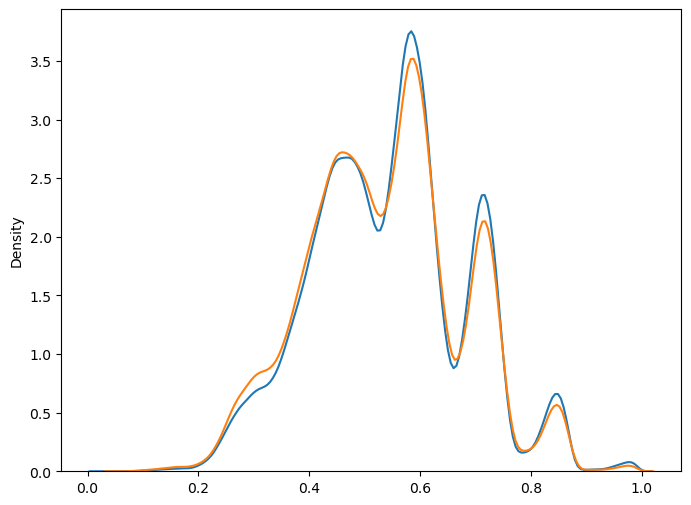

In [44]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.kdeplot(data=cos_sim_raveled_1,ax=ax, common_grid=True);
sns.kdeplot(data=cos_sim_raveled_2,ax=ax, common_grid=True);

In [45]:
avg_cos_sim_3,  cos_sim_raveled_3 = compute_avg_cosine_similarity(good_zeros, bad_zeros)
avg_cos_sim_4,  cos_sim_raveled_4 = compute_avg_cosine_similarity(good_zeros, bad_ones)

avg_cos_sim_3, avg_cos_sim_4

(0.5247886062227887, 0.5242963507300278)

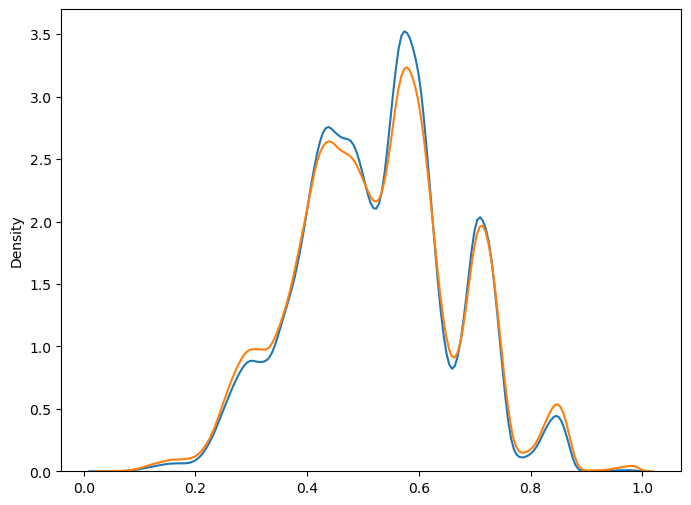

In [46]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.kdeplot(data=cos_sim_raveled_3,ax=ax, common_grid=True);
sns.kdeplot(data=cos_sim_raveled_4,ax=ax, common_grid=True);

After a bit of thinking, cosine similarities do not give insight on whether two clusters of samples belong to the same label.

In [47]:
def compute_avg_similarity(mat_a, mat_b):
    sim = mat_a.dot(mat_b.T)
    #a_norm = np.linalg.norm(mat_a, axis=1, keepdims=True)
    #b_norm = np.linalg.norm(mat_b, axis=1, keepdims=True)
    #cos_sim = sim/(a_norm*b_norm.T)
    sim_raveled = np.ravel(sim)
    avg_sim = np.mean(sim_raveled)
    
    return avg_sim, sim_raveled

In [48]:
avg_sim_1,  sim_raveled_1 = compute_avg_similarity(good_ones, bad_zeros)
avg_sim_2,  sim_raveled_2 = compute_avg_similarity(good_ones, bad_ones)
avg_sim_1, avg_sim_2

(4.310348092154286, 4.271484754072718)

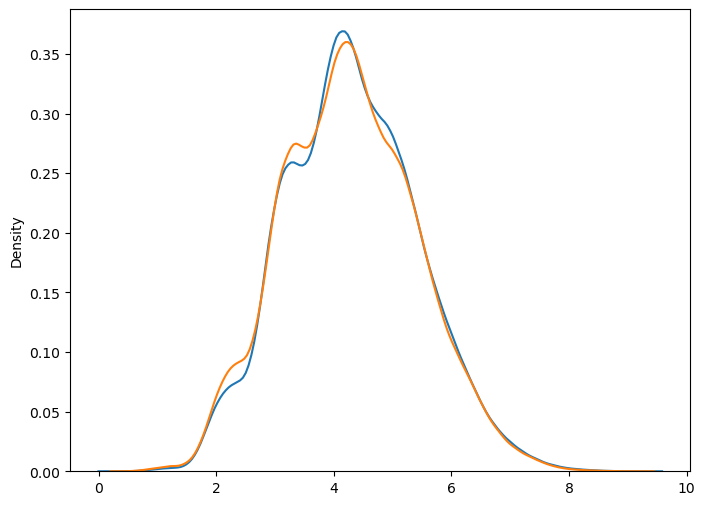

In [49]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.kdeplot(data=sim_raveled_1,ax=ax, common_grid=True);
sns.kdeplot(data=sim_raveled_2,ax=ax, common_grid=True);

In [50]:
avg_sim_3,  sim_raveled_3 = compute_avg_similarity(good_zeros, bad_zeros)
avg_sim_4,  sim_raveled_4 = compute_avg_similarity(good_zeros, bad_ones)

avg_sim_3, avg_sim_4

(4.129605833665276, 4.152270014867177)

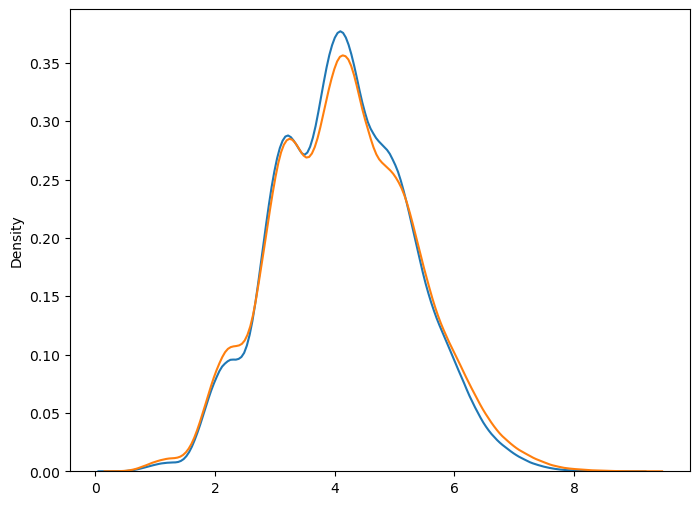

In [51]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.kdeplot(data=sim_raveled_3,ax=ax, common_grid=True);
sns.kdeplot(data=sim_raveled_4,ax=ax, common_grid=True);

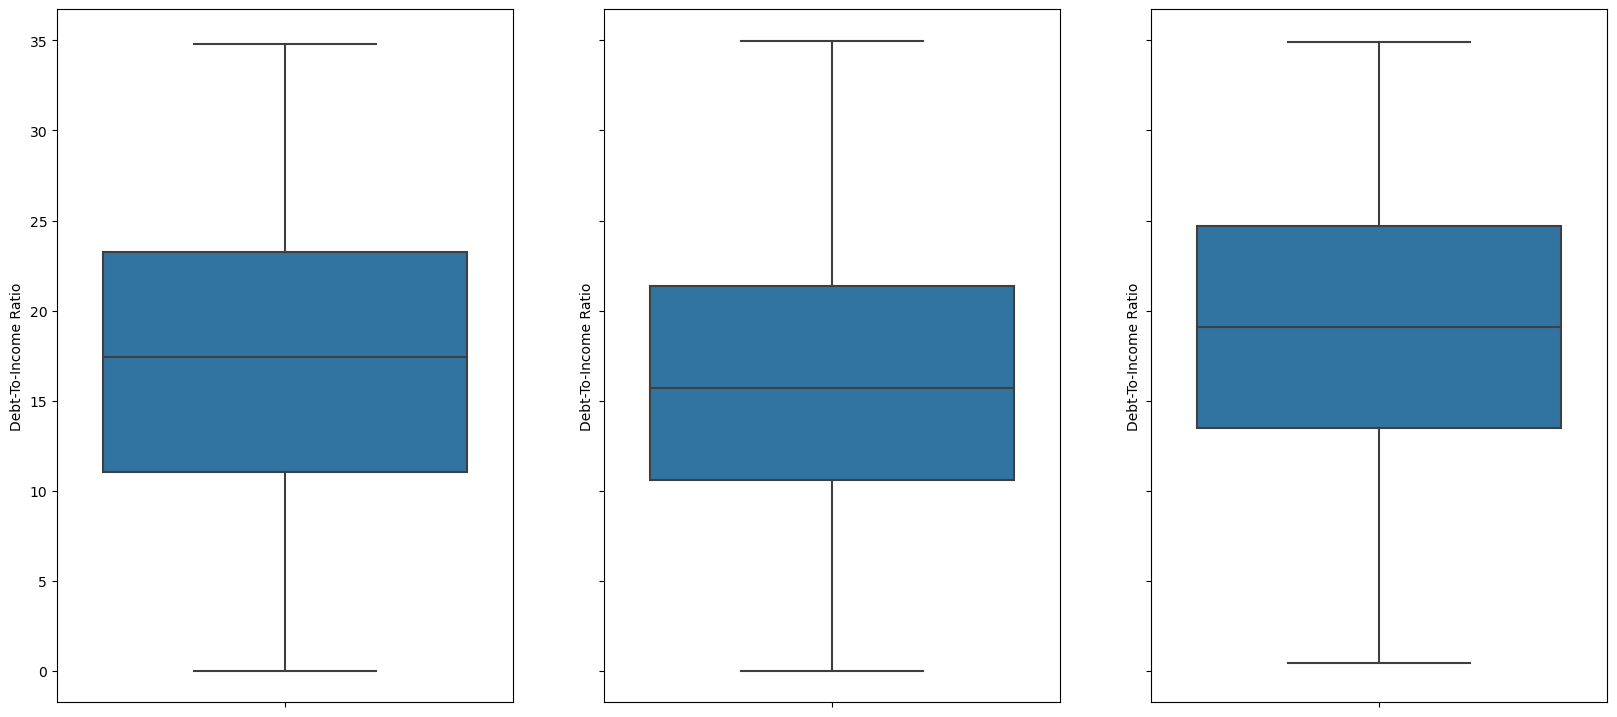

In [52]:
fig,ax = plt.subplots(1,3,figsize=(20,9), sharey=True)

sns.boxplot(y='Debt-To-Income Ratio',
                data=good_ones_for_graph, 
                ax=ax[0]);

sns.boxplot(y='Debt-To-Income Ratio',
                data=bad_zeros_for_graph, 
                ax=ax[1]);

sns.boxplot(y='Debt-To-Income Ratio',
                data=bad_ones_for_graph, 
                ax=ax[2]);

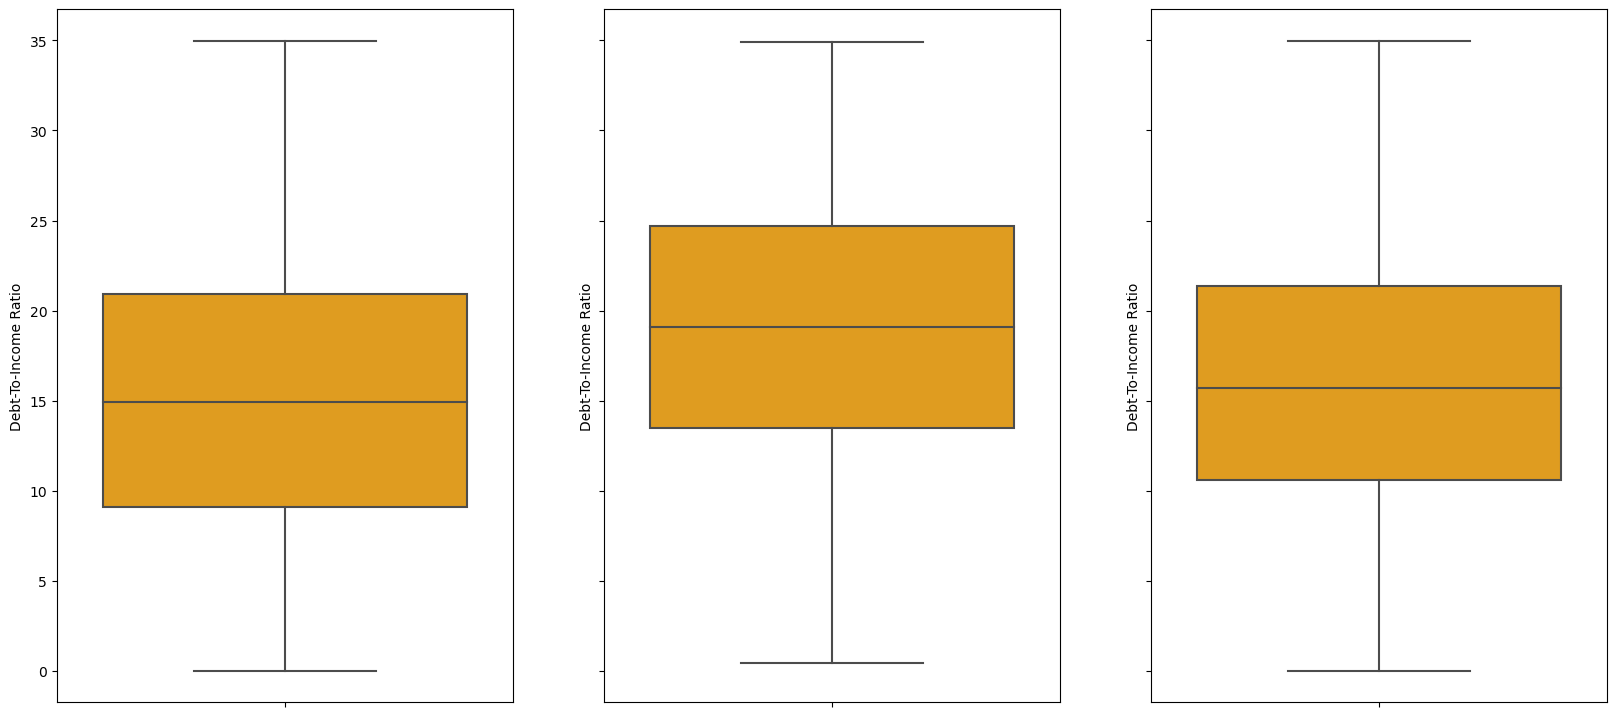

In [53]:
fig,ax = plt.subplots(1,3,figsize=(20,9), sharey=True)

sns.boxplot(y='Debt-To-Income Ratio',
                data=good_zeros_for_graph,
                color='orange',
                ax=ax[0]);

sns.boxplot(y='Debt-To-Income Ratio',
                data=bad_ones_for_graph, 
                color='orange',
                ax=ax[1]);

sns.boxplot(y='Debt-To-Income Ratio',
                data=bad_zeros_for_graph, 
                color='orange',
                ax=ax[2]);

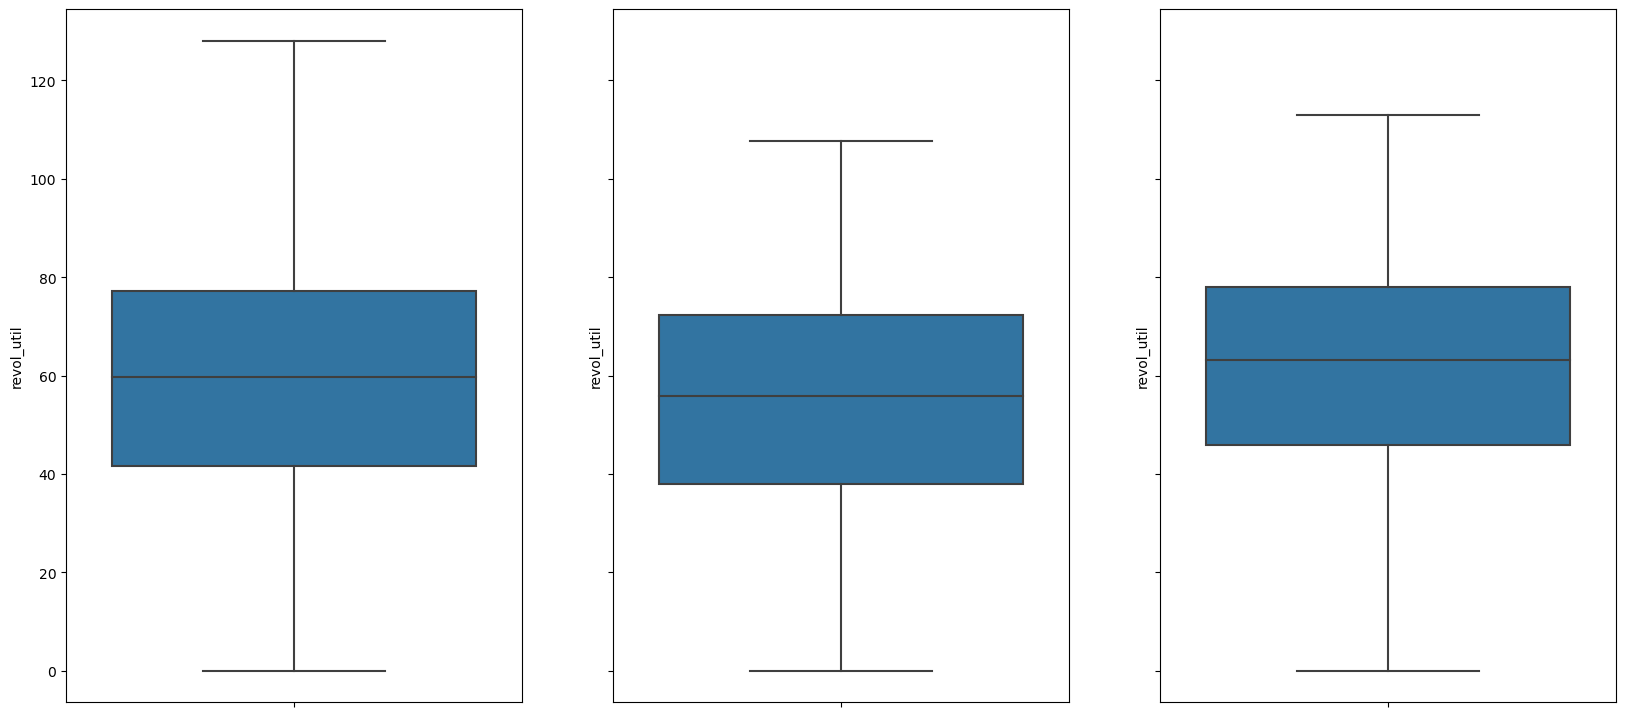

In [54]:
fig,ax = plt.subplots(1,3,figsize=(20,9), sharey=True)

sns.boxplot(y='revol_util',
                data=good_ones_for_graph, 
                ax=ax[0]);

sns.boxplot(y='revol_util',
                data=bad_zeros_for_graph, 
                ax=ax[1]);

sns.boxplot(y='revol_util',
                data=bad_ones_for_graph, 
                ax=ax[2]);

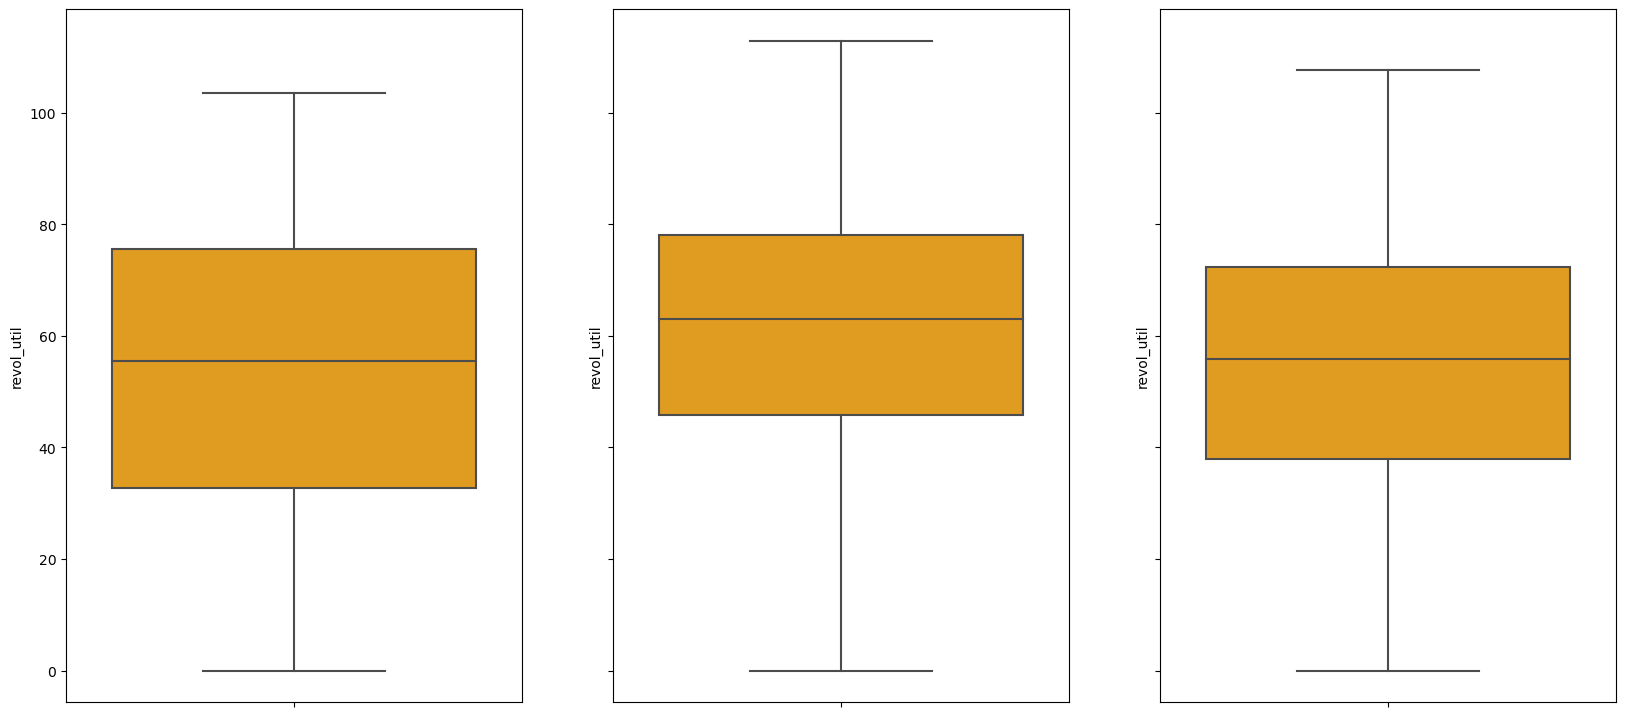

In [55]:
fig,ax = plt.subplots(1,3,figsize=(20,9), sharey=True)

sns.boxplot(y='revol_util',
                data=good_zeros_for_graph,
                color='orange',
                ax=ax[0]);

sns.boxplot(y='revol_util',
                data=bad_ones_for_graph, 
                color='orange',
                ax=ax[1]);

sns.boxplot(y='revol_util',
                data=bad_zeros_for_graph, 
                color='orange',
                ax=ax[2]);

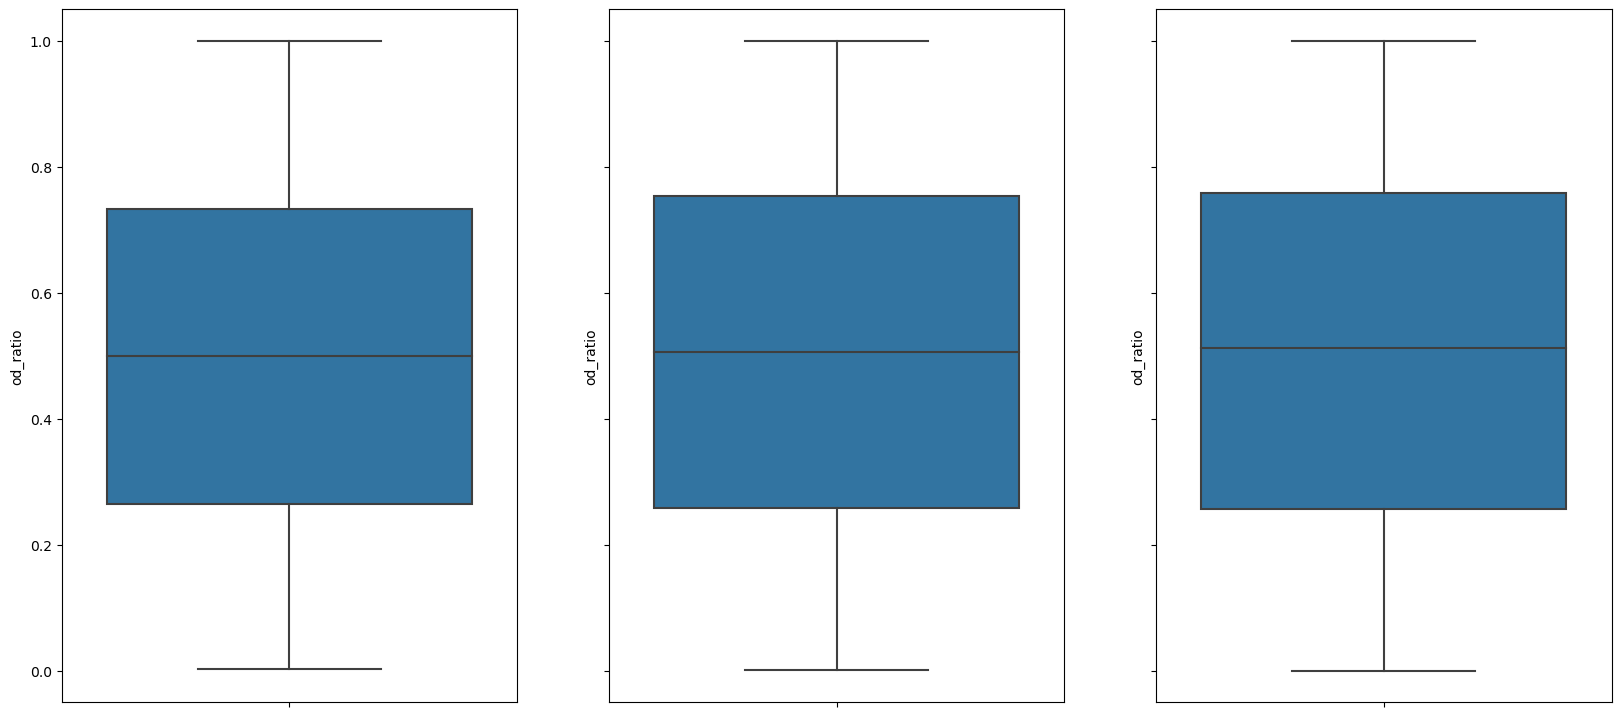

In [56]:
fig,ax = plt.subplots(1,3,figsize=(20,9), sharey=True)

sns.boxplot(y='od_ratio',
                data=good_ones_for_graph, 
                ax=ax[0]);

sns.boxplot(y='od_ratio',
                data=bad_zeros_for_graph, 
                ax=ax[1]);

sns.boxplot(y='od_ratio',
                data=bad_ones_for_graph, 
                ax=ax[2]);

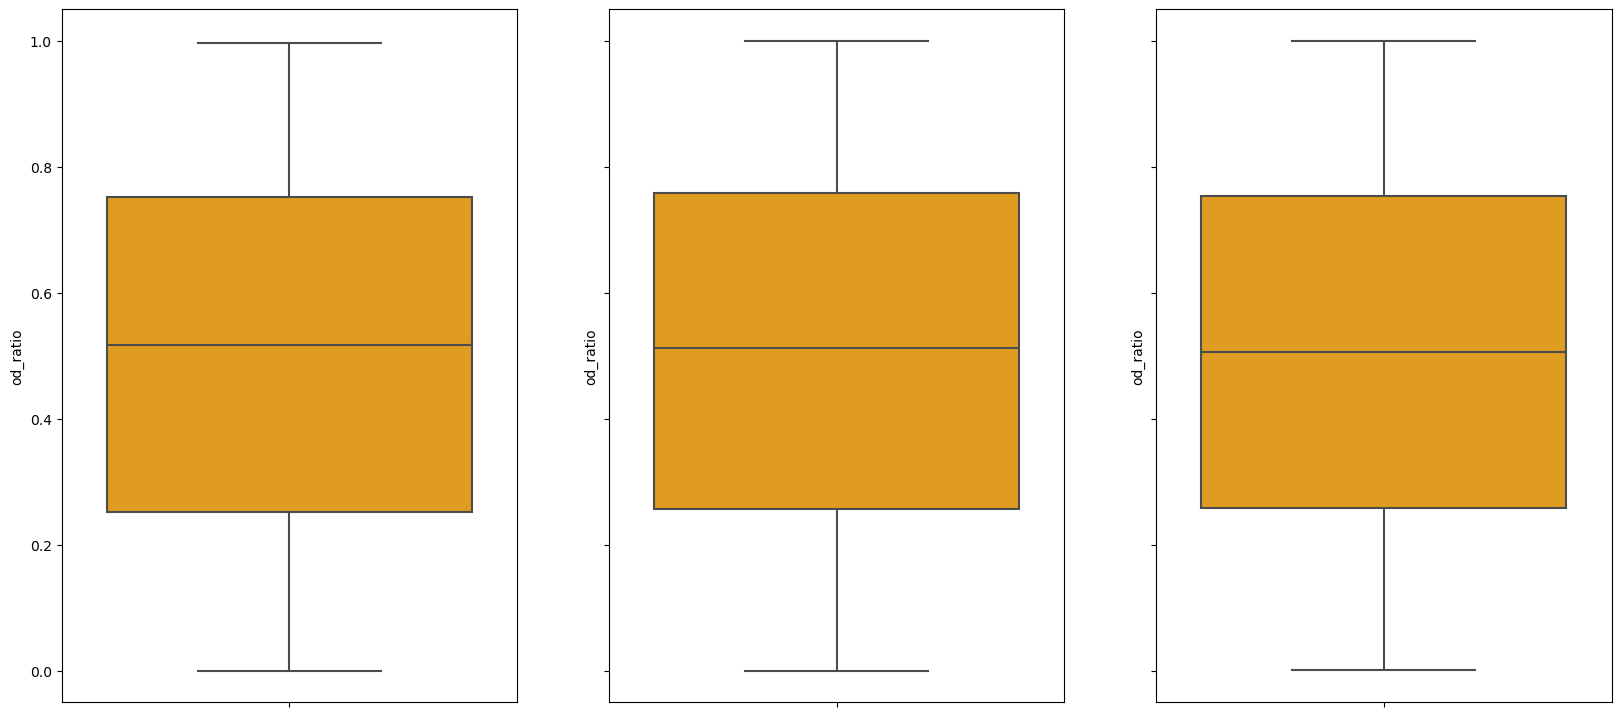

In [57]:
fig,ax = plt.subplots(1,3,figsize=(20,9), sharey=True)

sns.boxplot(y='od_ratio',
                data=good_zeros_for_graph,
                color='orange',
                ax=ax[0]);

sns.boxplot(y='od_ratio',
                data=bad_ones_for_graph, 
                color='orange',
                ax=ax[1]);

sns.boxplot(y='od_ratio',
                data=bad_zeros_for_graph, 
                color='orange',
                ax=ax[2]);

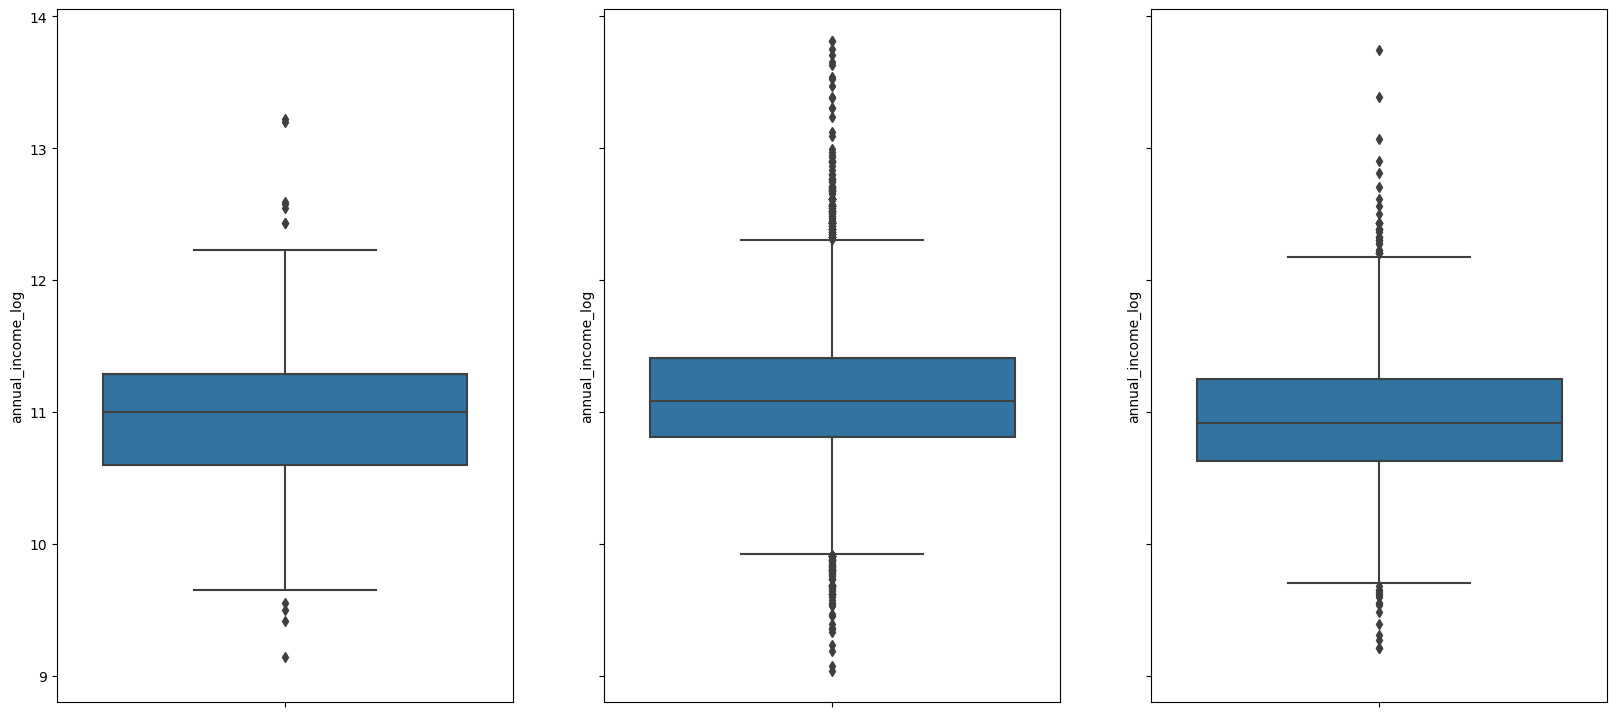

In [58]:
fig,ax = plt.subplots(1,3,figsize=(20,9), sharey=True)

sns.boxplot(y='annual_income_log',
                data=good_ones_for_graph, 
                ax=ax[0]);

sns.boxplot(y='annual_income_log',
                data=bad_zeros_for_graph, 
                ax=ax[1]);

sns.boxplot(y='annual_income_log',
                data=bad_ones_for_graph, 
                ax=ax[2]);

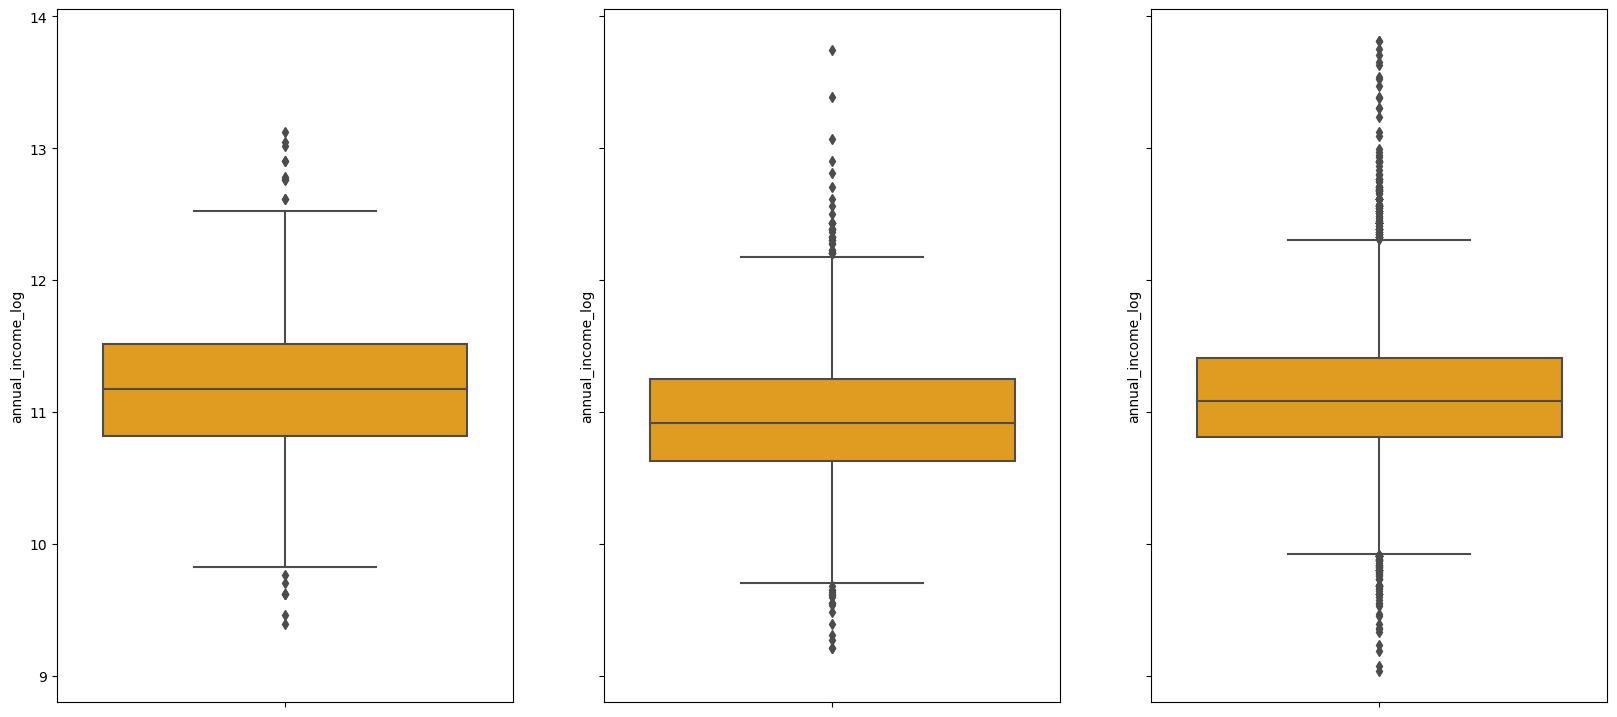

In [59]:
fig,ax = plt.subplots(1,3,figsize=(20,9), sharey=True)

sns.boxplot(y='annual_income_log',
                data=good_zeros_for_graph,
                color='orange',
                ax=ax[0]);

sns.boxplot(y='annual_income_log',
                data=bad_ones_for_graph, 
                color='orange',
                ax=ax[1]);

sns.boxplot(y='annual_income_log',
                data=bad_zeros_for_graph, 
                color='orange',
                ax=ax[2]);

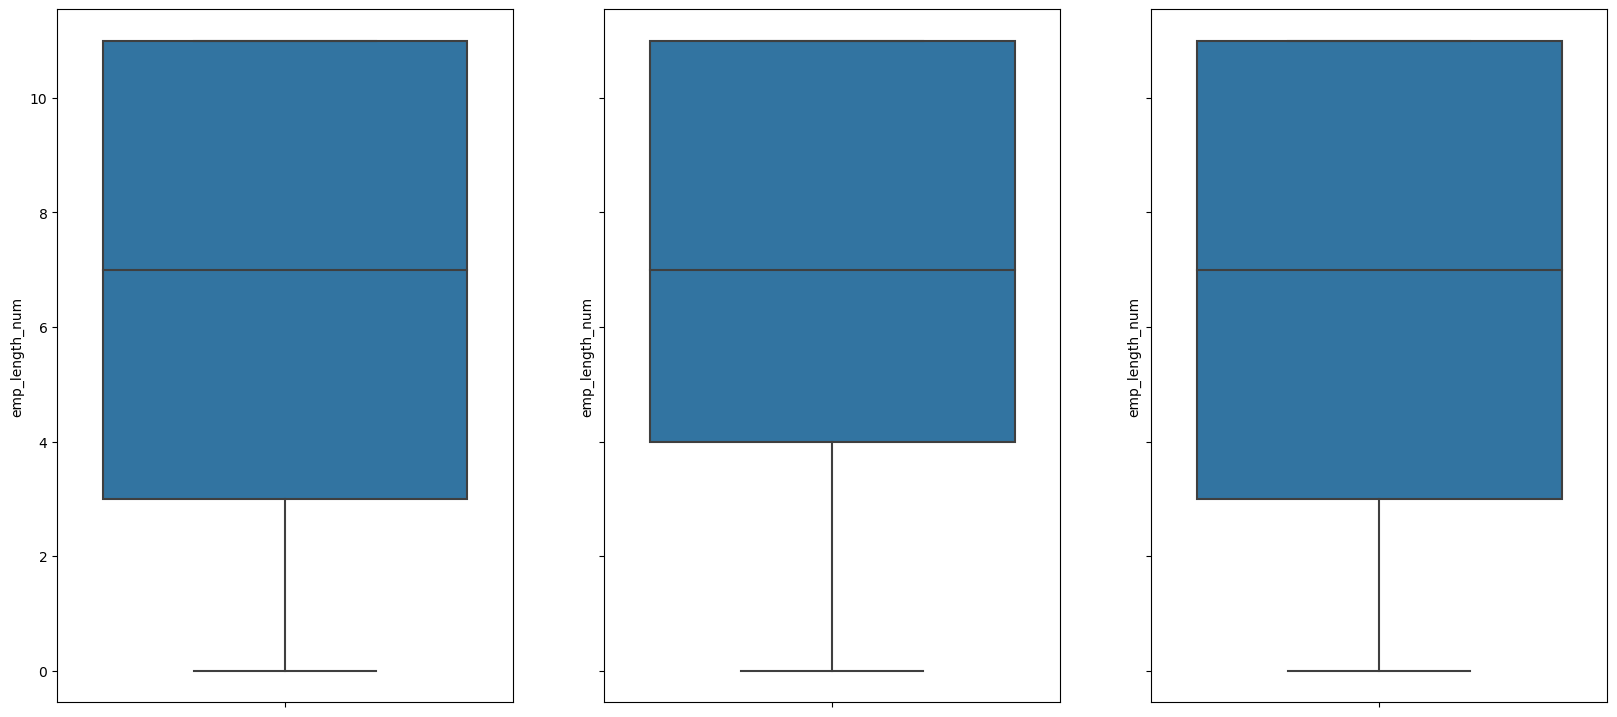

In [60]:
fig,ax = plt.subplots(1,3,figsize=(20,9), sharey=True)

sns.boxplot(y='emp_length_num',
                data=good_ones_for_graph, 
                ax=ax[0]);

sns.boxplot(y='emp_length_num',
                data=bad_zeros_for_graph, 
                ax=ax[1]);

sns.boxplot(y='emp_length_num',
                data=bad_ones_for_graph, 
                ax=ax[2]);

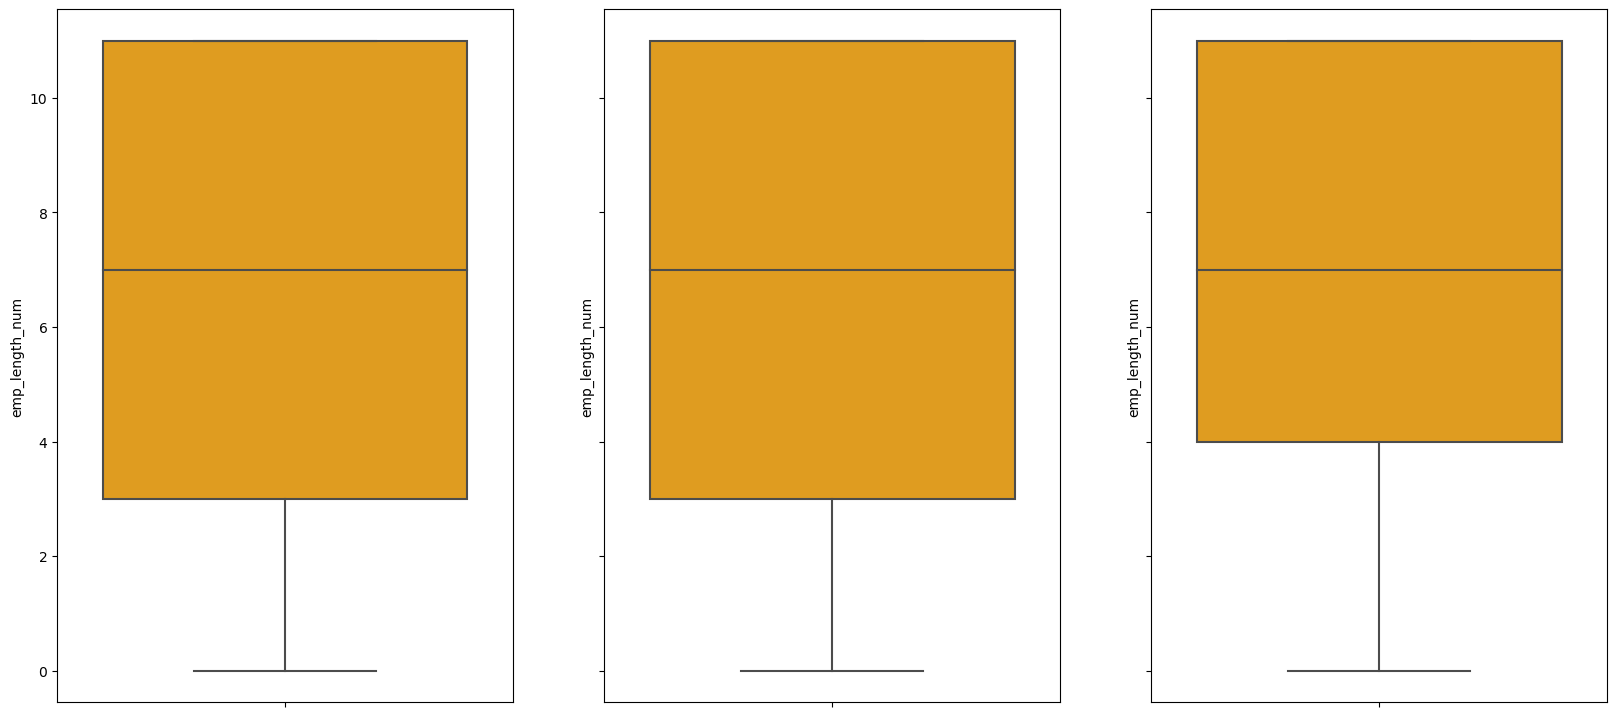

In [61]:
fig,ax = plt.subplots(1,3,figsize=(20,9), sharey=True)

sns.boxplot(y='emp_length_num',
                data=good_zeros_for_graph,
                color='orange',
                ax=ax[0]);

sns.boxplot(y='emp_length_num',
                data=bad_ones_for_graph, 
                color='orange',
                ax=ax[1]);

sns.boxplot(y='emp_length_num',
                data=bad_zeros_for_graph, 
                color='orange',
                ax=ax[2]);

In [62]:
def generate_scatterplots_for_comparison(x_y_tuples = tuple(), data_list = list()):
    
    fig,ax = plt.subplots(1,3,figsize=(20,9), sharey=True)
    sns.scatterplot(x=x_y_tuples[0],
                    y=x_y_tuples[1],
                    data=data_list[0],
                    ax=ax[0]);

    sns.scatterplot(x=x_y_tuples[0],
                    y=x_y_tuples[1],
                    data=data_list[1], 
                    ax=ax[1]);

    sns.scatterplot(x=x_y_tuples[0],
                    y=x_y_tuples[1],
                    data=data_list[2], 
                    ax=ax[2]);

In [63]:
features_to_inspect = ['Debt-To-Income Ratio','revol_util','od_ratio','annual_income_log']
good_zeros_data_list = [good_zeros_for_graph, bad_ones_for_graph, bad_zeros_for_graph]
good_ones_data_list = [good_ones_for_graph, bad_zeros_for_graph, bad_ones_for_graph]
combined_data_list = [good_zeros_data_list, good_ones_data_list]

In [64]:
import itertools
a = itertools.combinations(features_to_inspect,2)
b = [i for i in a]
b[0]

('Debt-To-Income Ratio', 'revol_util')

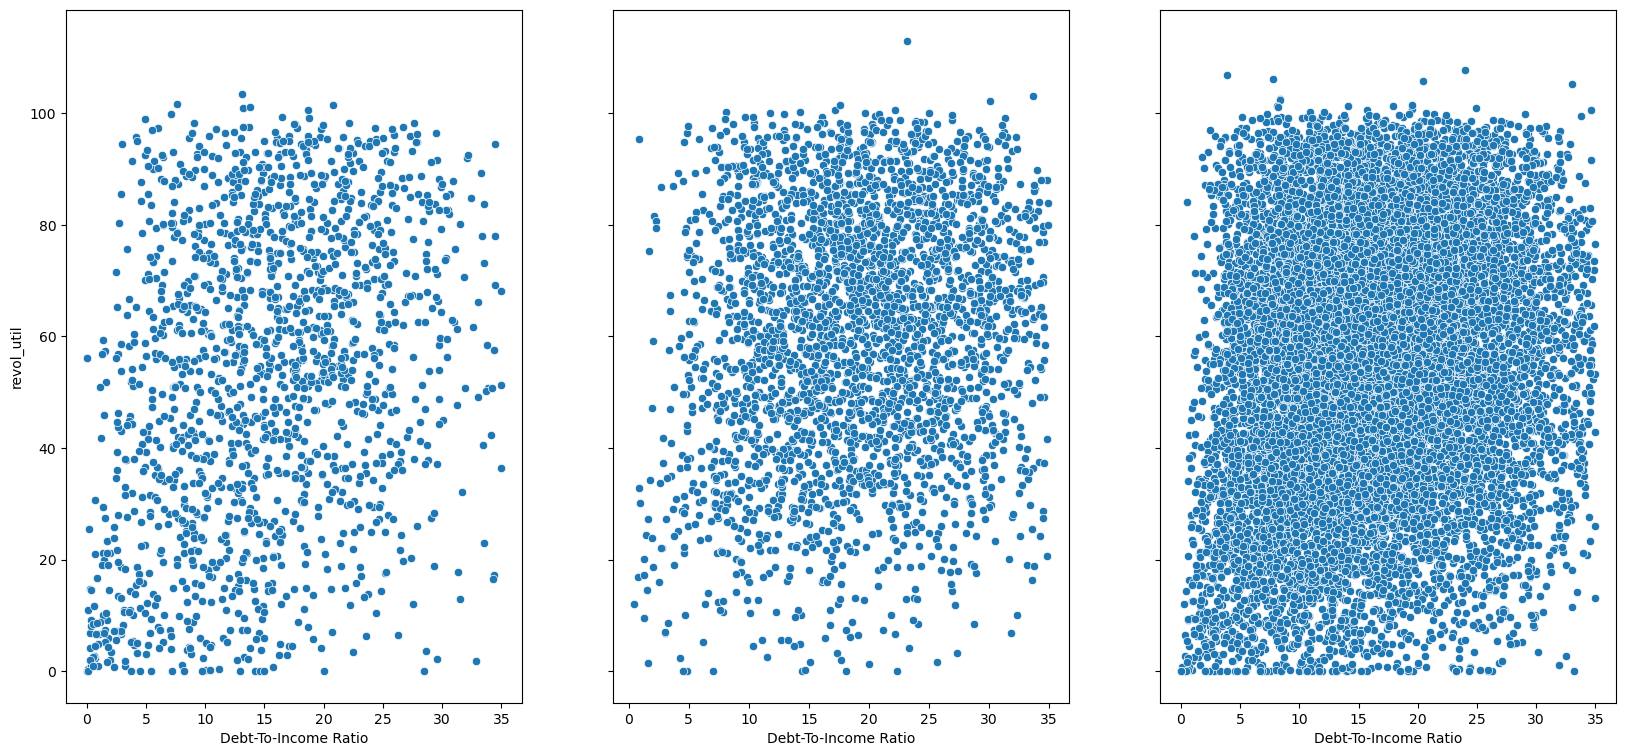

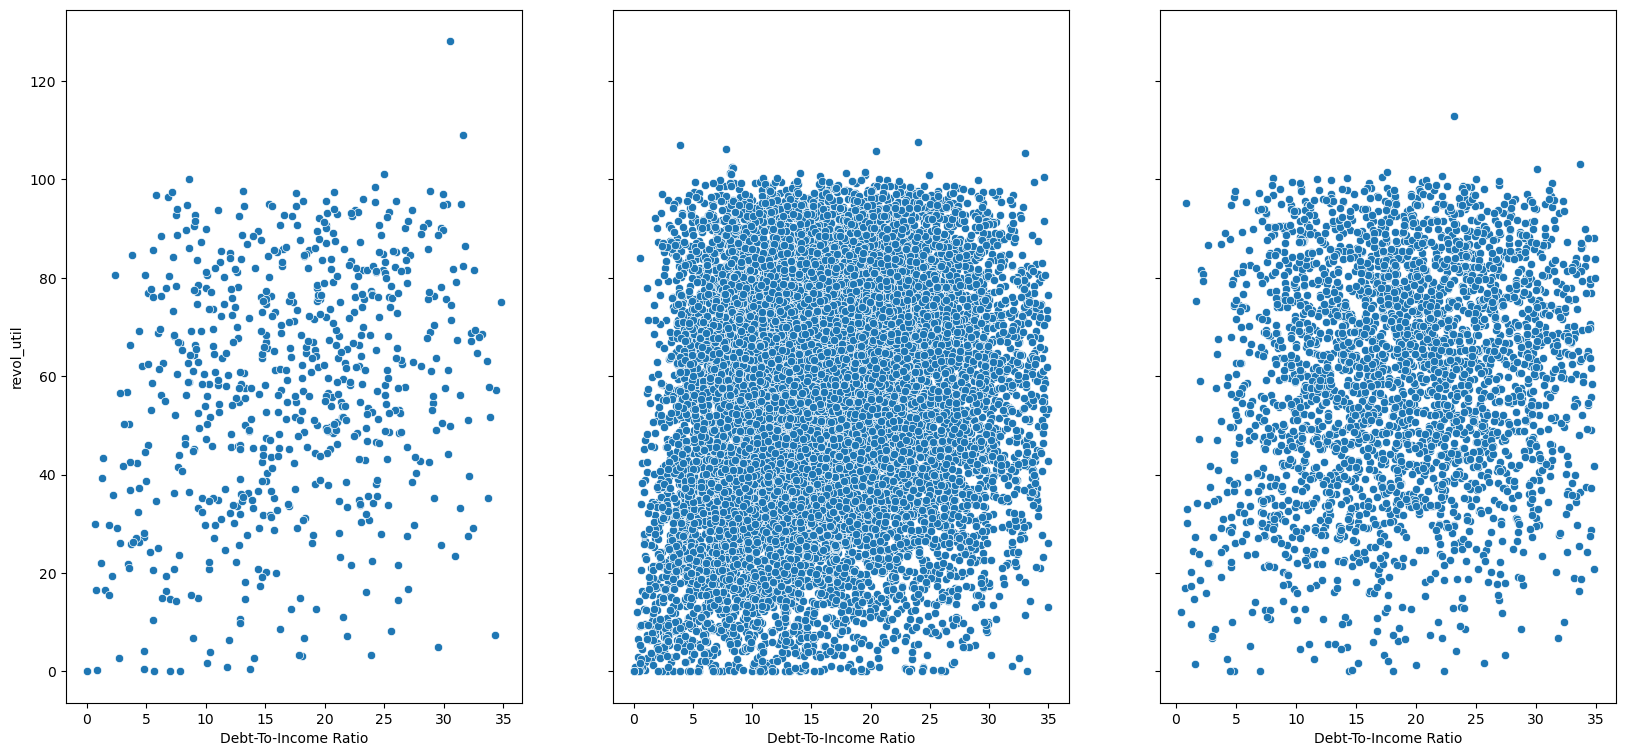

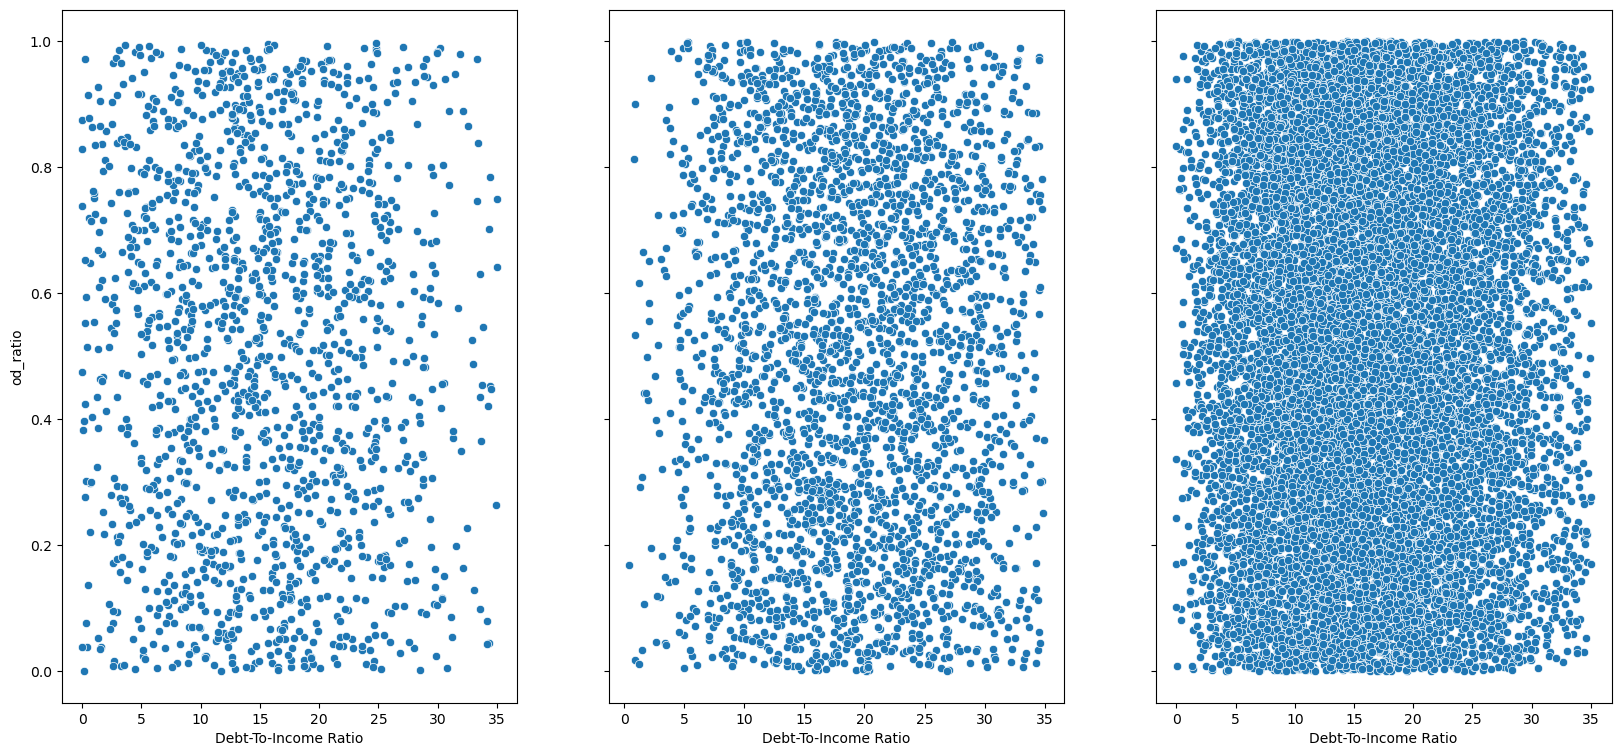

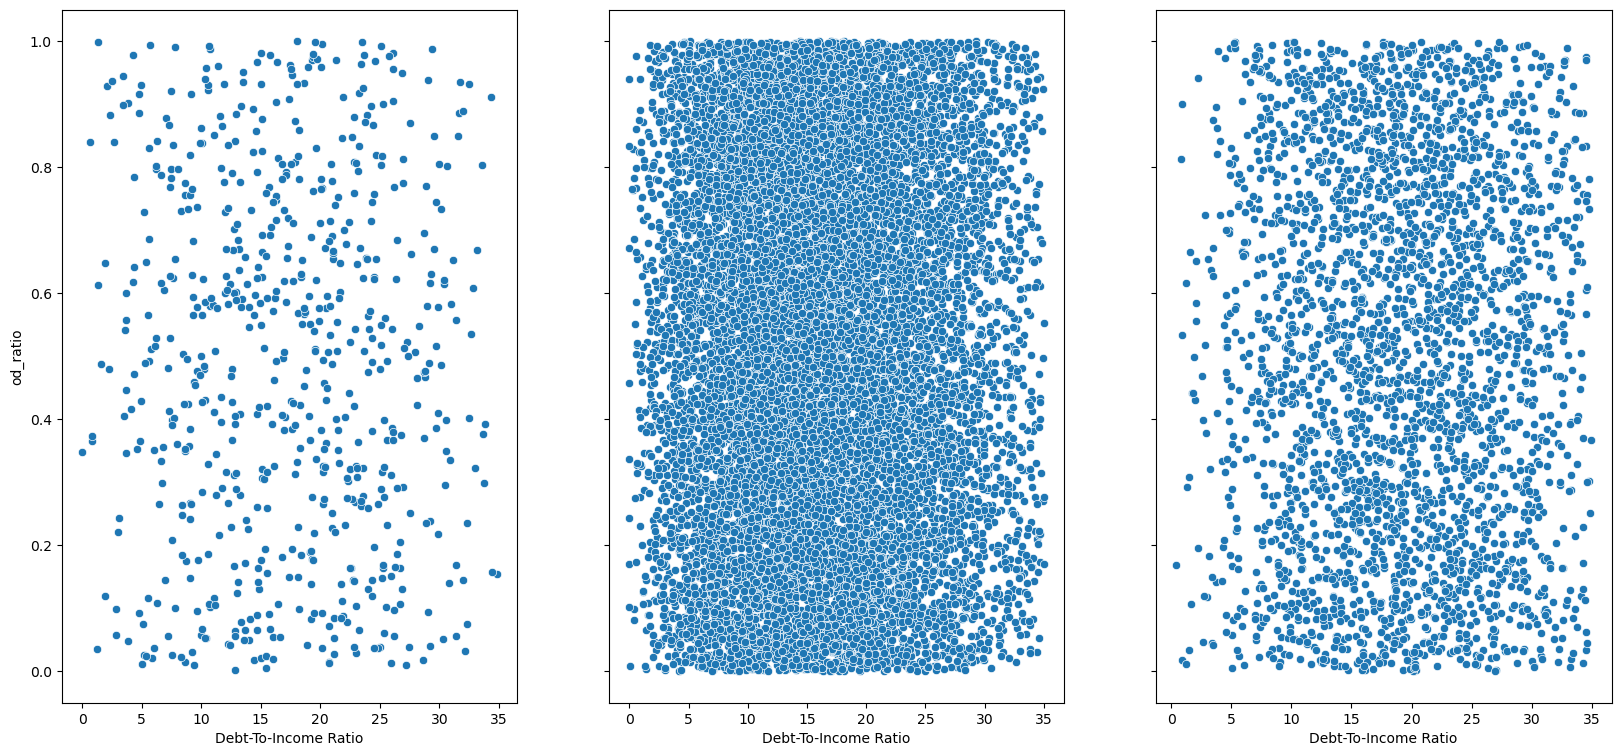

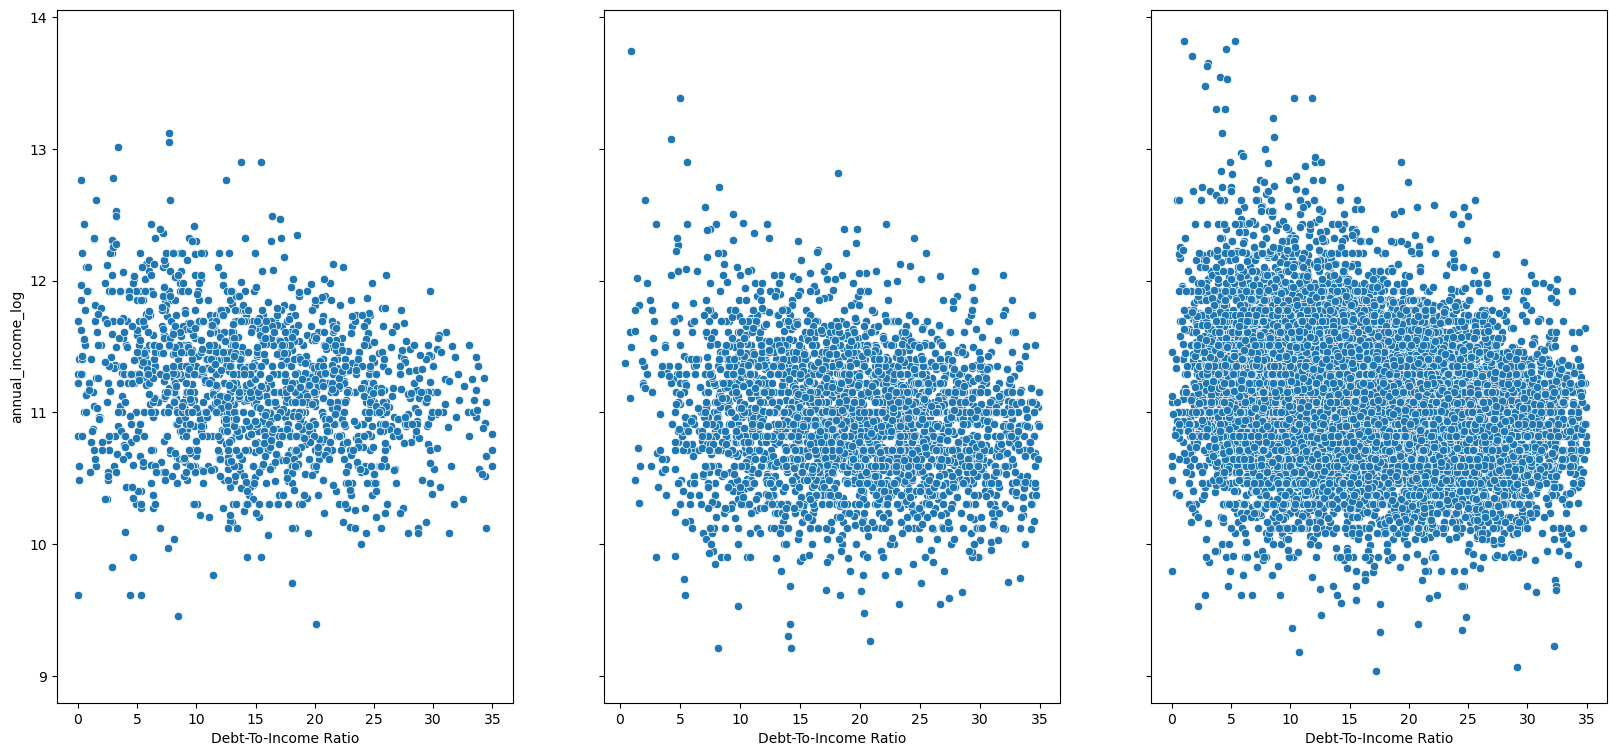

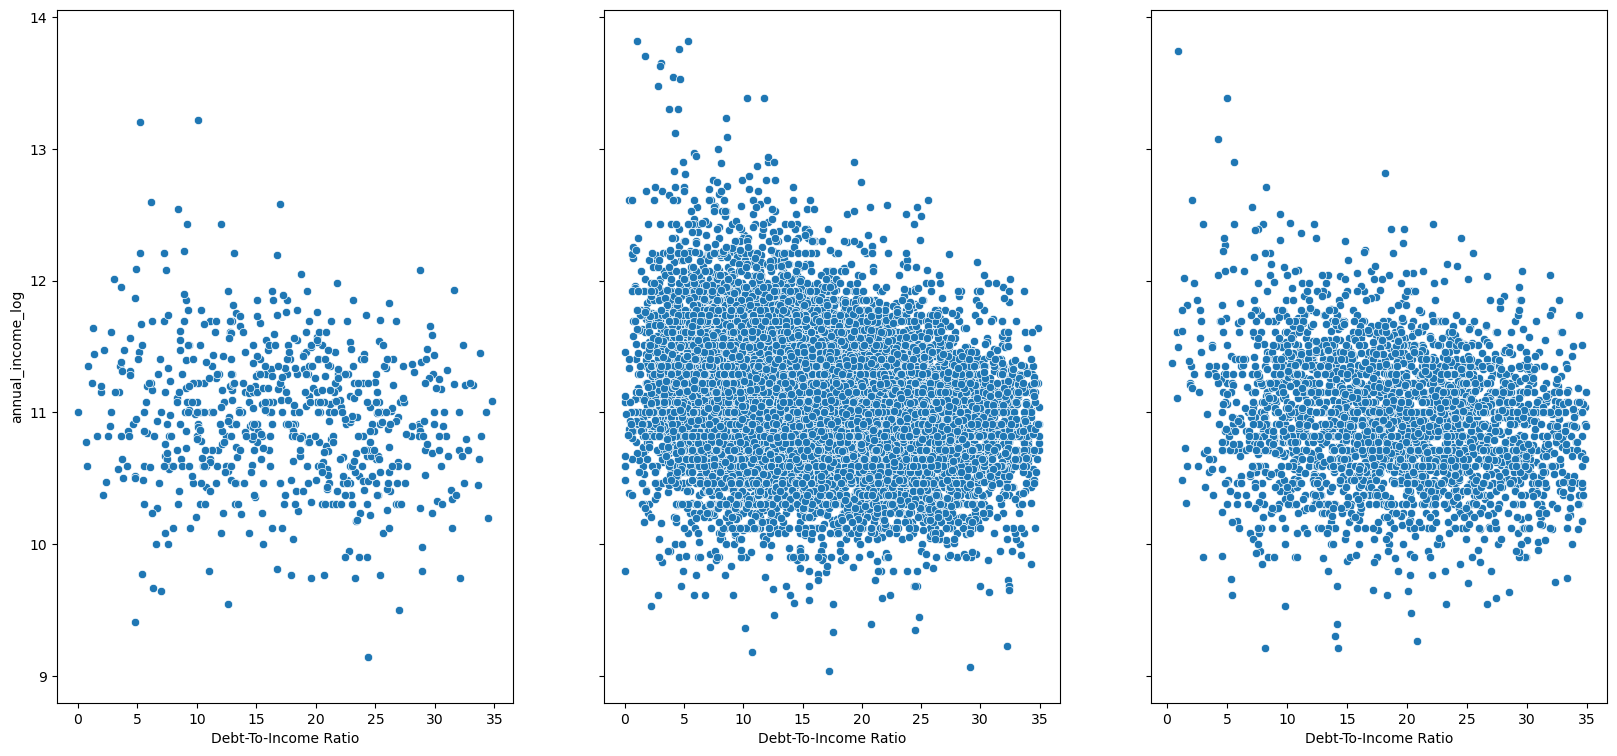

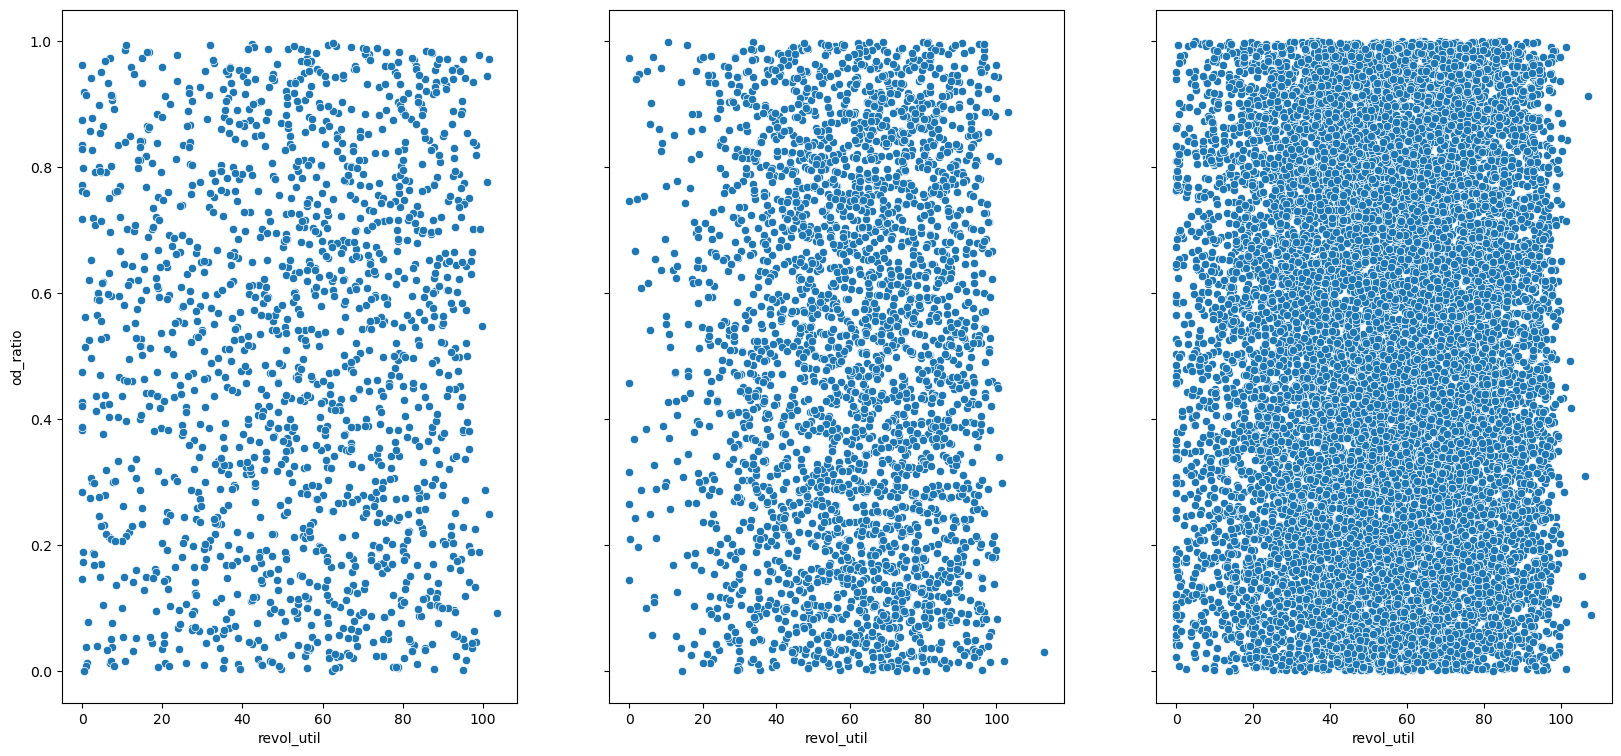

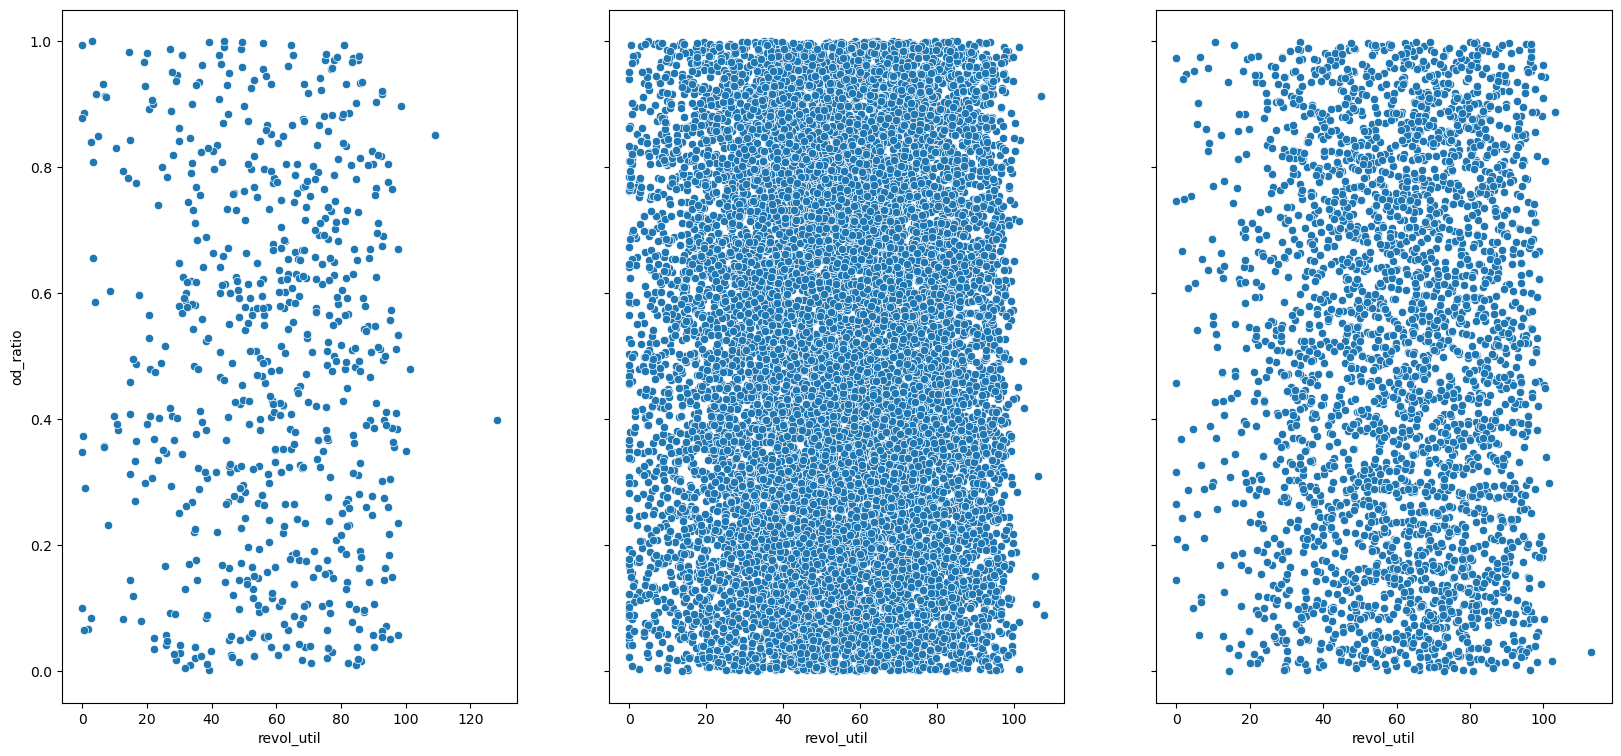

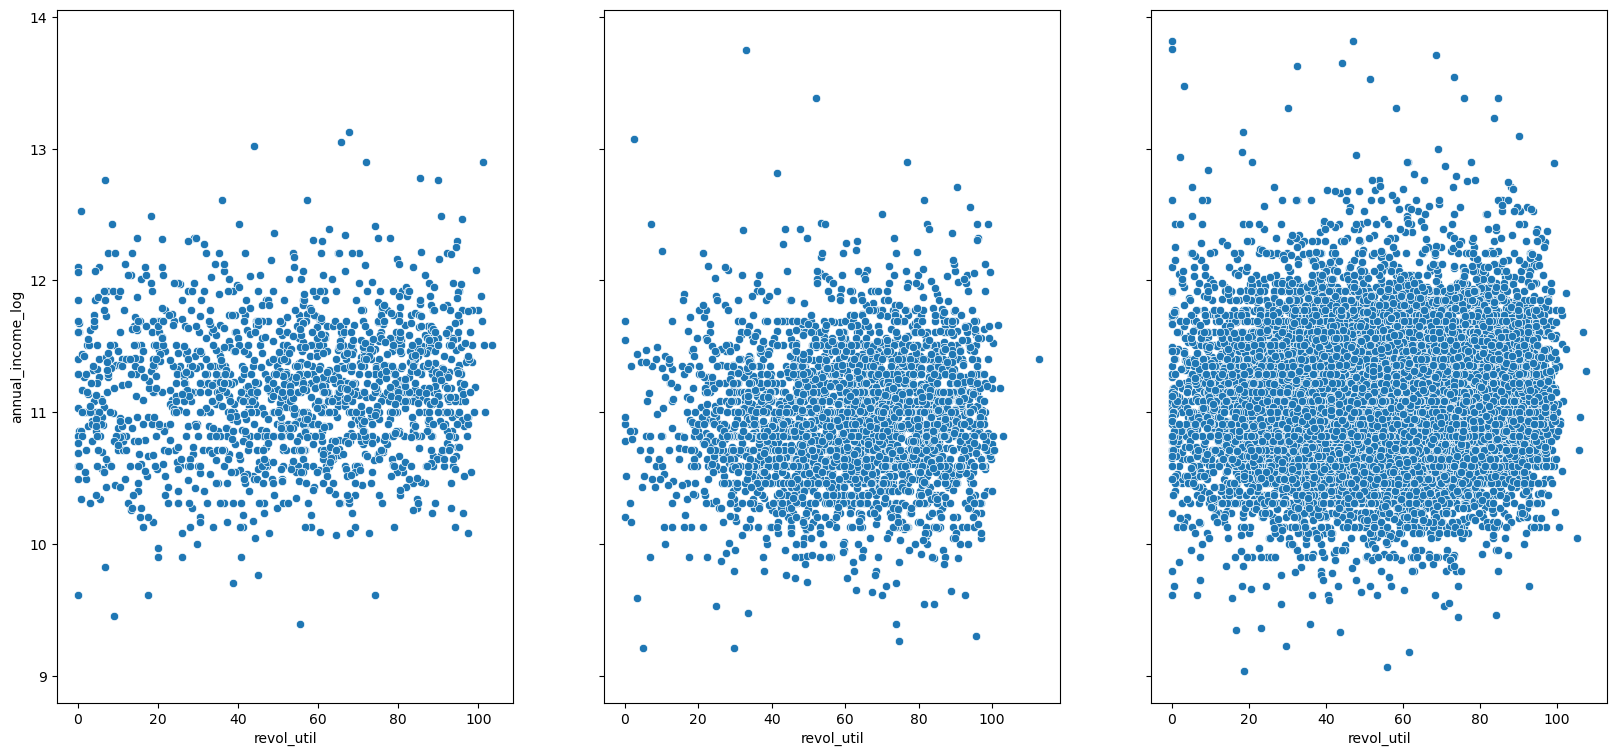

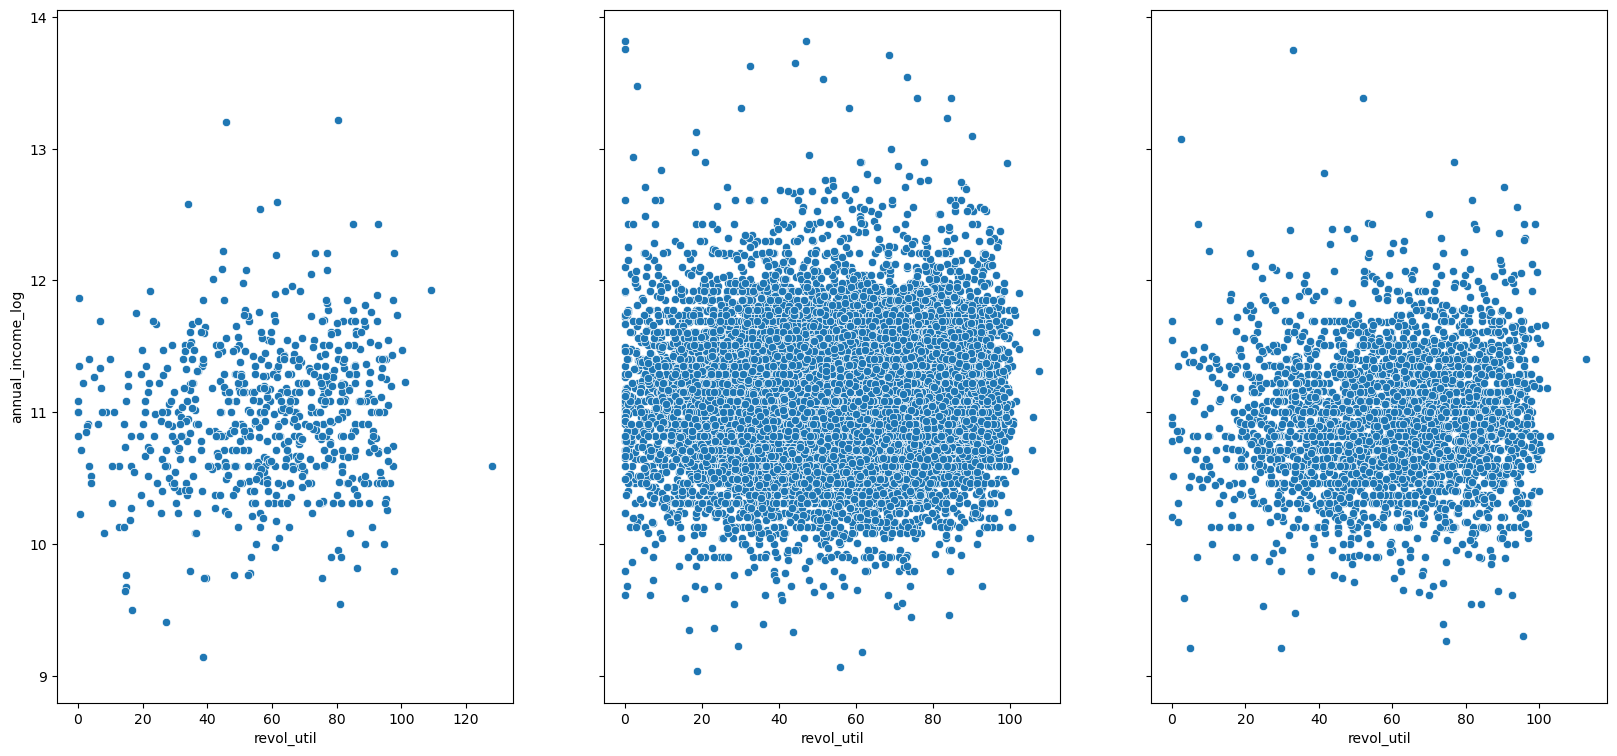

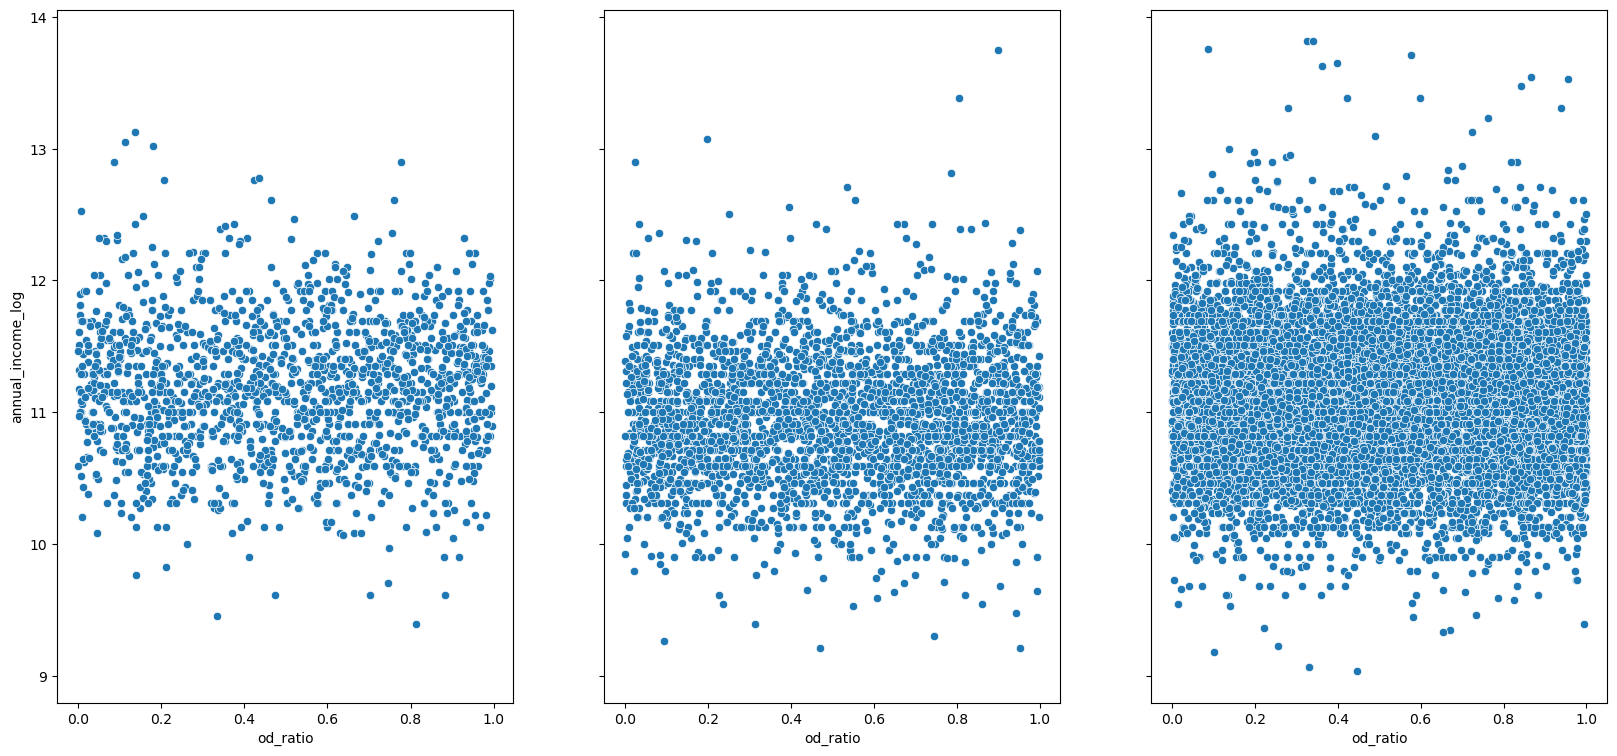

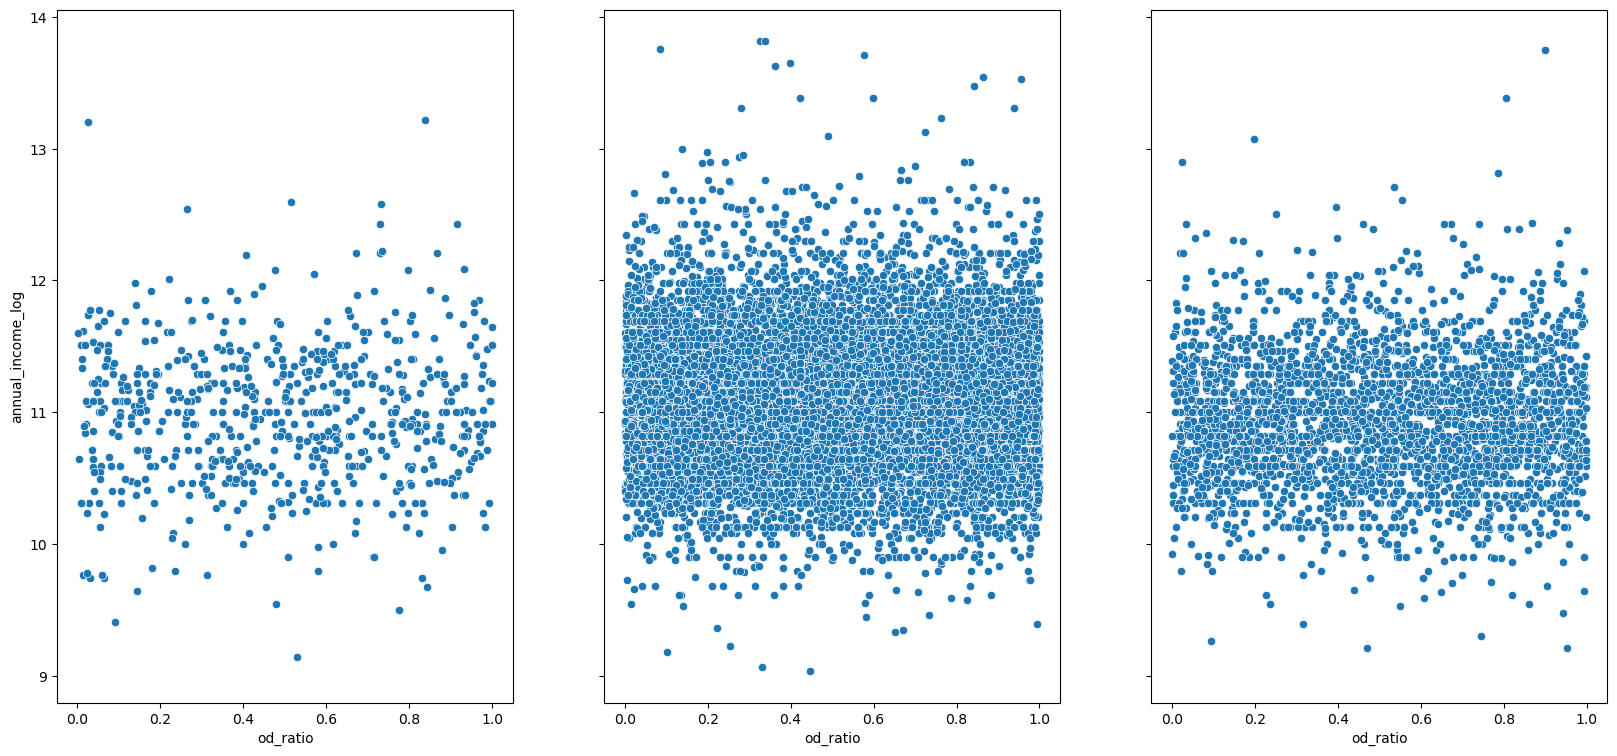

In [65]:
for tup in b:
    for data_list in combined_data_list:
        generate_scatterplots_for_comparison(tup,data_list)

In [66]:
#no evidence, but by logic, i will switch the sign of the bad data labels
df_bad['bad_loan'] = df_bad['bad_loan'].apply(lambda x: (x+1)%2) 
df_joined = pd.concat([df_bad,df_good])
df_joined.reset_index(inplace=True, drop=True)
df_joined.sort_index()

id  annual_income  short_employee  emp_length_num  \
0      11454641         100000               1               1   
1       9604874          83000               0               4   
2       9795013          65000               0              11   
3       7450630          96000               1               1   
4       9767996          60000               0              11   
...         ...            ...             ...             ...   
18365   6605561          35000               0               9   
18366   6625566          93250               0               5   
18367   6625631          75000               0               5   
18368   6605587          26400               0               2   
18369   6605649          90000               0               3   

       Debt-To-Income Ratio  revol_util  total_rec_late_fee  od_ratio  \
0                     26.27        43.2              0.0000  0.160624   
1                      5.39        21.5              0.0000  0.810777   
2                     11.26        15.2              0.0000  0.166500   
3                      6.41        55.9              0.0000  0.238576   
4                     26.27        94.1              0.0000  0.674835   
...                     ...         ...                 ...       ...   
18365                 27.50        29.8             14.9974  0.250783   
18366                  1.35        43.3             22.2130  0.612265   
18367                  6.01        25.1             52.6500  0.350997   
18368                 23.44        16.2              0.0000  0.269905   
18369                  9.65        32.4              0.0000  0.578386   

       bad_loan  grade_A  grade_B  grade_C  grade_D  grade_E  grade_F  \
0             1        1        0        0        0        0        0   
1             1        1        0        0        0        0        0   
2             1        0        0        0        1        0        0   
3             1        0        0        0        1        0        0   
4             1        0        0        0        0        0        0   
...         ...      ...      ...      ...      ...      ...      ...   
18365         1        0        0        1        0        0        0   
18366         1        0        0        1        0        0        0   
18367         1        0        0        1        0        0        0   
18368         1        0        0        0        0        0        1   
18369         1        0        0        0        0        0        1   

       grade_G  home_ownership_MORTGAGE  home_ownership_OWN  \
0            0                        0                   0   
1            0                        0                   1   
2            0                        1                   0   
3            0                        0                   0   
4            1                        1                   0   
...        ...                      ...                 ...   
18365        0                        0                   0   
18366        0                        0                   0   
18367        0                        1                   0   
18368        0                        0                   0   
18369        0                        1                   0   

       home_ownership_RENT  purpose_car  purpose_credit_card  \
0                        1            0                    1   
1                        0            0                    1   
2                        0            0                    0   
3                        1            0                    0   
4                        0            0                    0   
...                    ...          ...                  ...   
18365                    1            0                    0   
18366                    1            0                    1   
18367                    0            0                    0   
18368                    1            0                    0   
18369

In [67]:
df_joined.columns

Index(['id', 'annual_income', 'short_employee', 'emp_length_num',
       'Debt-To-Income Ratio', 'revol_util', 'total_rec_late_fee', 'od_ratio',
       'bad_loan', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_36 months',
       'term_60 months', 'last_delinq_none_0', 'last_delinq_none_1',
       'last_major_derog_none_0.0', 'last_major_derog_none_1.0',
       'last_major_derog_none_missing', 'annual_income_log'],
      dtype='object')

In [68]:
X = df_joined.drop(columns=['id', 'annual_income','bad_loan','grade_A',
                     'home_ownership_MORTGAGE','purpose_car','term_36 months',
                     'last_delinq_none_0', 'last_major_derog_none_0.0'])

y = df_joined['bad_loan'].astype(int)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [69]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

### Logistic Regression

In [70]:
param_grid = [{'C': [790, 800, 810]}]

lg_clf = LogisticRegression(class_weight='balanced',
                            random_state = 123
                           )
     
grid_search = GridSearchCV(lg_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)
               
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 790}

In [71]:
lg_clf = grid_search.best_estimator_
lg_clf.fit(X_train, y_train)
y_pred = lg_clf.predict(X_test)
y_score = lg_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

Predicted Negative  Predicted Positive
Actual Negative                 645                 270
Actual Positive                 478                2281

In [72]:
lg_precision, lg_recall, lg_pr_auc, lg_fpr, lg_tpr, lg_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.93. ROC AUC is 0.85, Accuracy is 0.80


### XGBoost

In [73]:
param_grid = [
    {'n_estimators': [50, 60, 70, 80],
     'max_depth': [5, 6, 7, 8, 9, 10],
     'learning_rate': [0.01, 0.1, 1]}]

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                    eval_metric='logloss',
                                    scale_pos_weight=class_weights[0]/class_weights[1],
                                    random_state = 123)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50}

In [74]:
xgb_classifier = grid_search.best_estimator_
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
y_score = xgb_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

Predicted Negative  Predicted Positive
Actual Negative                 388                 527
Actual Positive                  18                2741

In [75]:
xgb_precision, xgb_recall, xgb_pr_auc, xgb_fpr, xgb_tpr, xgb_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.93. ROC AUC is 0.85, Accuracy is 0.85


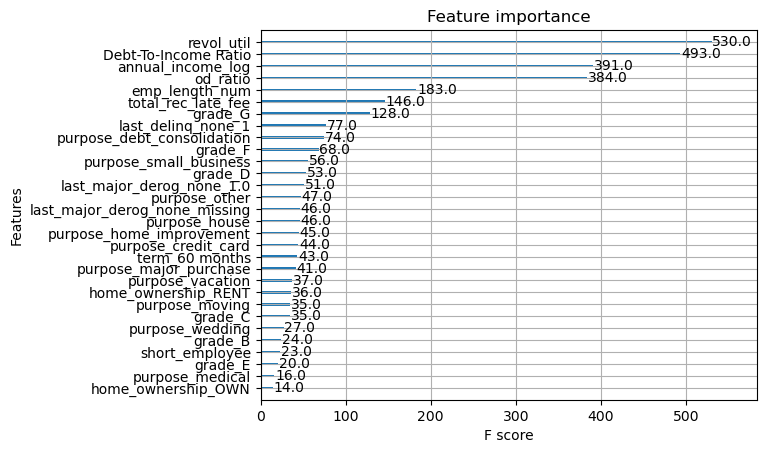

In [76]:
xgb_classifier.get_booster().feature_names =  list(X.columns)
xgb.plot_importance(xgb_classifier);

### Random Forest

In [77]:
param_grid = [
    {'n_estimators': [350, 400, 450],
     'max_depth': [5, 10, 15]}
]

rf_classifier = RandomForestClassifier(class_weight=class_weights,
                                       random_state = 123)

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 15, 'n_estimators': 350}

In [78]:
best_params = grid_search.best_estimator_
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
y_score = rf_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

Predicted Negative  Predicted Positive
Actual Negative                 418                 497
Actual Positive                  72                2687

In [79]:
rf_precision, rf_recall, rf_pr_auc, rf_fpr, rf_tpr, rf_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.92. ROC AUC is 0.83, Accuracy is 0.85


In [80]:
feature_names = list(X.columns)
feature_importances = list()

for name, score in zip(feature_names, rf_classifier.feature_importances_):
    p = (name, score)
    feature_importances.append(p)

feature_importances = sorted(feature_importances, key=lambda x:x[1],reverse=True)
feature_importances

[('Debt-To-Income Ratio', 0.13988618541797793),
 ('revol_util', 0.13405815002658708),
 ('annual_income_log', 0.1290265112062404),
 ('od_ratio', 0.1288452408635985),
 ('emp_length_num', 0.06463708836796433),
 ('grade_F', 0.05650016256043113),
 ('purpose_major_purchase', 0.040723077164967585),
 ('last_major_derog_none_1.0', 0.029020536049077224),
 ('term_60 months', 0.026783478363064103),
 ('purpose_small_business', 0.022728318015035623),
 ('last_delinq_none_1', 0.01995844521500396),
 ('last_major_derog_none_missing', 0.017788788180291164),
 ('grade_B', 0.017655342917865524),
 ('home_ownership_RENT', 0.017238787642220227),
 ('purpose_other', 0.016588212804512417),
 ('purpose_home_improvement', 0.014879651654097135),
 ('purpose_debt_consolidation', 0.014074424085051093),
 ('grade_D', 0.013452347901479996),
 ('grade_C', 0.012688515195728877),
 ('purpose_credit_card', 0.01109132415264619),
 ('purpose_moving', 0.010756627080674437),
 ('grade_E', 0.00906966246939472),
 ('home_ownership_OWN', 

#### Gradient Descent Optimization

In [81]:
param_grid = [
    {'max_iter': list(range(0, 951, 100))}
]

sgd_clf = SGDClassifier(loss='log', 
                        learning_rate='optimal',
                        tol=1e-3,
                        class_weight=class_weights,
                        random_state = 123)

grid_search = GridSearchCV(sgd_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_iter': 100}

In [82]:
sgd_clf = grid_search.best_estimator_
sgd_clf.fit(X_train, y_train)
y_pred = sgd_clf.predict(X_test)
y_score = sgd_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

Predicted Negative  Predicted Positive
Actual Negative                 641                 274
Actual Positive                 562                2197

In [83]:
sgd_precision, sgd_recall, sgd_pr_auc, sgd_fpr, sgd_tpr, sgd_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.92. ROC AUC is 0.84, Accuracy is 0.77


### Mini-batch Gradient Descent

In [84]:
from sklearn.base import clone

sgd_clf = SGDClassifier(loss='log', 
                        learning_rate='optimal',
                        tol=1e-3,
                        class_weight=class_weights,
                        random_state = 123)

batch_size = 150
sample_size = len(X_train)

#set aside a validation batch for mini-batch SGD
sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=batch_size, train_size=sample_size-batch_size)
train_ind, val_ind = next(sss_2.split(X_train, y_train))
X_train_2, y_train_2, X_mini_val, y_mini_val = X_train[list(train_ind)], y_train.iloc[train_ind], X_train[list(val_ind)], y_train.iloc[val_ind]
y_train_2 = y_train_2.to_numpy().reshape(-1,1)
combined_training_data = np.concatenate((X_train_2, y_train_2), axis = 1)

minimum_val_error = float("inf") 
best_model = None

for i in range(100):
    
    np.random.shuffle(combined_training_data)
    
    X_mini_train = combined_training_data[0:batch_size, :-1]
    y_mini_train = combined_training_data[0:batch_size, -1]
                                          
    sgd_clf.partial_fit(X_mini_train, y_mini_train, classes=np.unique(y_train_2))
    y_val_proba = sgd_clf.predict_proba(X_mini_val)
    val_error = log_loss(y_mini_val, y_val_proba)
    
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_model = clone(sgd_clf)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)


Predicted Negative  Predicted Positive
Actual Negative                 641                 274
Actual Positive                 562                2197

In [85]:
mbgd_precision, mbgd_recall, mbgd_pr_auc, mbgd_fpr, mbgd_tpr, mbgd_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.92. ROC AUC is 0.84, Accuracy is 0.77


In [86]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, log_loss, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

### Support Vector Machine

#### Linear SVM

In [87]:
param_grid = [
    {'max_iter': np.arange(2, 8, 1),
     'C': np.arange(1, 15, 1)}
]

lin_svm_clf = LinearSVC(dual=False, 
                        loss='squared_hinge',
                        random_state=123,
                        class_weight='balanced')

grid_search = GridSearchCV(lin_svm_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 12, 'max_iter': 7}

In [88]:
from sklearn.calibration import CalibratedClassifierCV

lin_svm_clf = grid_search.best_estimator_
lin_svm_clf.fit(X_train, y_train)
y_pred = lin_svm_clf.predict(X_test)

clf = CalibratedClassifierCV(grid_search.best_estimator_) 
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:,1]

get_confusion_matrix(y_test, y_pred)

Predicted Negative  Predicted Positive
Actual Negative                 640                 275
Actual Positive                 448                2311

In [89]:
lsvm_precision, lsvm_recall, lsvm_pr_auc, lsvm_fpr, lsvm_tpr, lsvm_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.93. ROC AUC is 0.85, Accuracy is 0.80


#### Polynomial Kernel Support Vector Classifier

SVC's time complexity is O(n^2 xd) to O(n^3 xd). To lower the time required to train kernel SVM models, i will use a smaller training dataset

In [90]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.8, train_size=0.2, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train_2, y_train_2, X_test_2, y_test_2 = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

In [91]:
param_grid = [
    {'degree': [0, 1, 2],
     'coef0': [1, 2],
     'C': [1, 10, 100, 1000]}
]

poly_kernel_svm_clf = SVC(kernel = 'poly',
                          probability = True,
                          class_weight=class_weights)

grid_search = GridSearchCV(poly_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True,
                          n_jobs=-1)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 1000, 'coef0': 1, 'degree': 1}

In [92]:
poly_kernel_svm_clf = grid_search.best_estimator_
poly_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = poly_kernel_svm_clf.predict(X_test_2)
y_score = poly_kernel_svm_clf.predict_proba(X_test_2)[:, 1]

get_confusion_matrix(y_test_2, y_pred)

Predicted Negative  Predicted Positive
Actual Negative                2358                1301
Actual Positive                2170                8867

In [93]:
pksvm_precision, pksvm_recall, pksvm_pr_auc, pksvm_fpr, pksvm_tpr, pksvm_roc_auc = get_metrics(y_test_2, y_score, y_pred)

PR AUC is 0.92. ROC AUC is 0.83, Accuracy is 0.76


#### Gaussian RBF Kernel Support Vector Classifier

In [94]:
param_grid = [
    {'gamma': [0.0001, 0.001, 0.01, 0.1],
     'C': [0.1, 1, 10, 100, 1000]}
]
#https://scikit-learn.org/stable/modules/svm.html#svm-kernels
rbf_kernel_svm_clf = SVC(kernel = 'rbf',
                         probability = True,
                         class_weight=class_weights)

grid_search = GridSearchCV(rbf_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True,
                          n_jobs=-1)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 1000, 'gamma': 0.0001}

In [95]:
rbf_kernel_svm_clf = grid_search.best_estimator_
rbf_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = rbf_kernel_svm_clf.predict(X_test_2)
y_score = rbf_kernel_svm_clf.predict_proba(X_test_2)[:, 1]

get_confusion_matrix(y_test_2, y_pred)

Predicted Negative  Predicted Positive
Actual Negative                2357                1302
Actual Positive                2178                8859

In [96]:
rbfksvm_precision, rbfksvm_recall, rbfksvm_pr_auc, rbfksvm_fpr, rbfksvm_tpr, rbfksvm_roc_auc = get_metrics(y_test_2, y_score, y_pred)

PR AUC is 0.92. ROC AUC is 0.82, Accuracy is 0.76


#### Stacking/Stacked Generalization

In [97]:
base_learners = [
    ('rf', rf_classifier),
    ('sgd', sgd_clf),
    ('xgb', xgb_classifier),
]

meta_learner = LogisticRegression(class_weight=class_weights)

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
y_score = stacking_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

Predicted Negative  Predicted Positive
Actual Negative                 625                 290
Actual Positive                 448                2311

In [98]:
stack_precision, stack_recall, stack_pr_auc, stack_fpr, stack_tpr, stack_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.93. ROC AUC is 0.85, Accuracy is 0.80


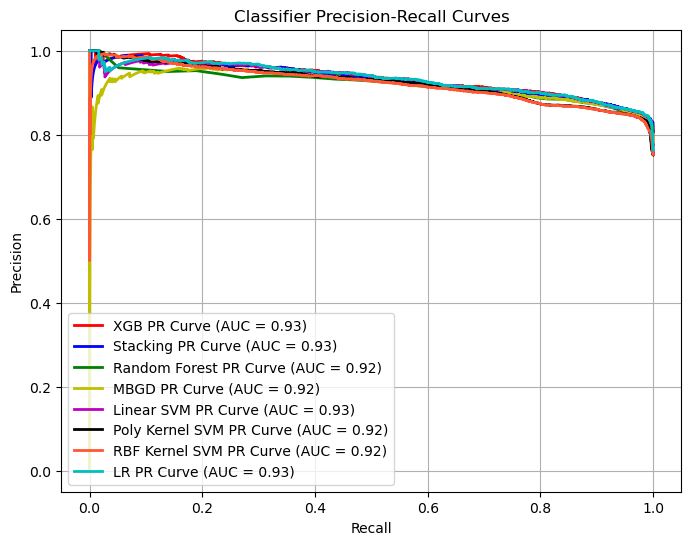

In [99]:
plt.figure(figsize=(8, 6))

plt.plot(xgb_recall, xgb_precision, color='r', lw=2, label=f'XGB PR Curve (AUC = {xgb_pr_auc:.2f})')
plt.plot(stack_recall, stack_precision, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stack_pr_auc:.2f})')
plt.plot(rf_recall, rf_precision, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_pr_auc:.2f})')
plt.plot(mbgd_recall, mbgd_precision, color='y', lw=2, label=f'MBGD PR Curve (AUC = {mbgd_pr_auc:.2f})')
plt.plot(lsvm_recall, lsvm_precision, color='m', lw=2, label=f'Linear SVM PR Curve (AUC = {lsvm_pr_auc:.2f})')
plt.plot(pksvm_recall, pksvm_precision, color='k', lw=2, label=f'Poly Kernel SVM PR Curve (AUC = {pksvm_pr_auc:.2f})')
plt.plot(rbfksvm_recall, rbfksvm_precision, color='#FF5733', lw=2, label=f'RBF Kernel SVM PR Curve (AUC = {rbfksvm_pr_auc:.2f})')
plt.plot(lg_recall, lg_precision, color='c', lw=2, label=f'LR PR Curve (AUC = {lg_pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Classifier Precision-Recall Curves')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

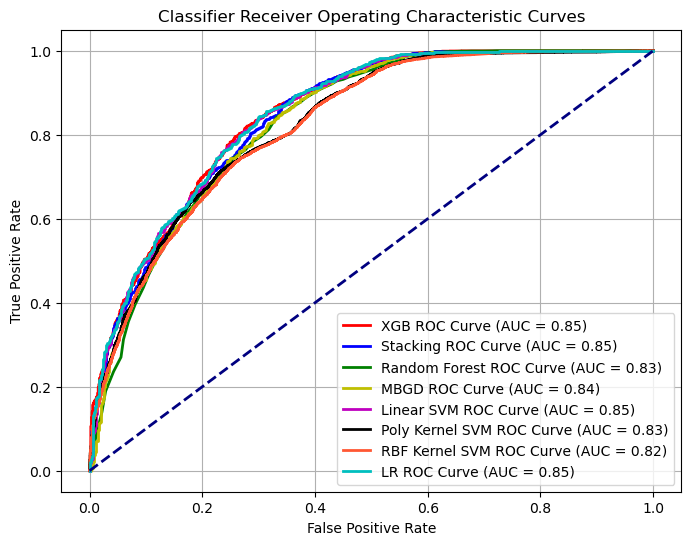

In [116]:
plt.figure(figsize=(8, 6))

plt.plot(xgb_fpr, xgb_tpr, color='r', lw=2, label=f'XGB ROC Curve (AUC = {xgb_roc_auc:.2f})')
plt.plot(stack_fpr, stack_tpr, color='b', lw=2, label=f'Stacking ROC Curve (AUC = {stack_roc_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, color='g', lw=2, label=f'Random Forest ROC Curve (AUC = {rf_roc_auc:.2f})')
plt.plot(mbgd_fpr, mbgd_tpr, color='y', lw=2, label=f'MBGD ROC Curve (AUC = {mbgd_roc_auc:.2f})')
plt.plot(lsvm_fpr, lsvm_tpr, color='m', lw=2, label=f'Linear SVM ROC Curve (AUC = {lsvm_roc_auc:.2f})')
plt.plot(pksvm_fpr, pksvm_tpr, color='k', lw=2, label=f'Poly Kernel SVM ROC Curve (AUC = {pksvm_roc_auc:.2f})')
plt.plot(rbfksvm_fpr, rbfksvm_tpr, color='#FF5733', lw=2, label=f'RBF Kernel SVM ROC Curve (AUC = {rbfksvm_roc_auc:.2f})')
plt.plot(lg_fpr, lg_tpr, color='c', lw=2, label=f'LR ROC Curve (AUC = {lg_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier Receiver Operating Characteristic Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

including this feature does not change PR AUC but boosts ROC AUC by 0.03 on average.

Curious about the new distributions

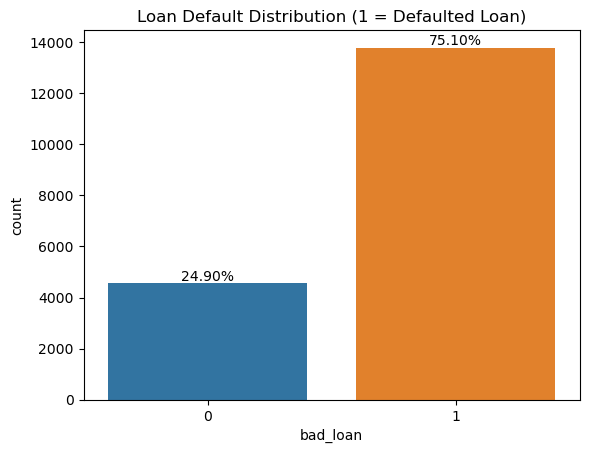

In [101]:
total_count = df_joined.bad_loan.size

ax = sns.countplot(x='bad_loan', data=df_joined)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100, f'{height/total_count*100:.2f}%', ha='center')

plt.title('Loan Default Distribution (1 = Defaulted Loan)')
plt.show()

#### Visualization of Categorical Features' Distributions

In [102]:
df_joined.columns

Index(['id', 'annual_income', 'short_employee', 'emp_length_num',
       'Debt-To-Income Ratio', 'revol_util', 'total_rec_late_fee', 'od_ratio',
       'bad_loan', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_36 months',
       'term_60 months', 'last_delinq_none_0', 'last_delinq_none_1',
       'last_major_derog_none_0.0', 'last_major_derog_none_1.0',
       'last_major_derog_none_missing', 'annual_income_log'],
      dtype='object')

In [103]:
original_cols = ['grade','home','purpose', 'term','last']
df_joined_copied = df_joined.copy() #df_joined_copied is throw-away for graphing categorical features' distributions only

In [104]:
for col in original_cols:
    df_joined_copied[col] = pd.Series(dtype=str)

for encoded_col in df_joined.columns:
    feature_name = encoded_col.split('_')[0]
    if feature_name not in original_cols:
        continue
    special_char_index = encoded_col.index('_')
    sliced_string = encoded_col[special_char_index+1:]
    indices = df_joined[df_joined[encoded_col]==1].index
    df_joined_copied.loc[indices, feature_name]=sliced_string

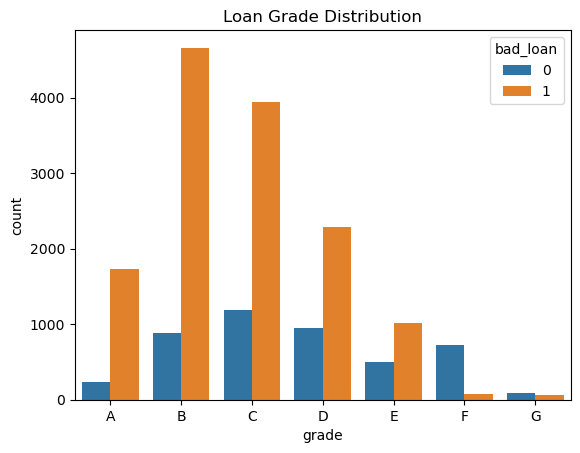

In [105]:
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.countplot(x=df_joined_copied.grade, hue=df_joined_copied.bad_loan, order=grade_order);
plt.title('Loan Grade Distribution');

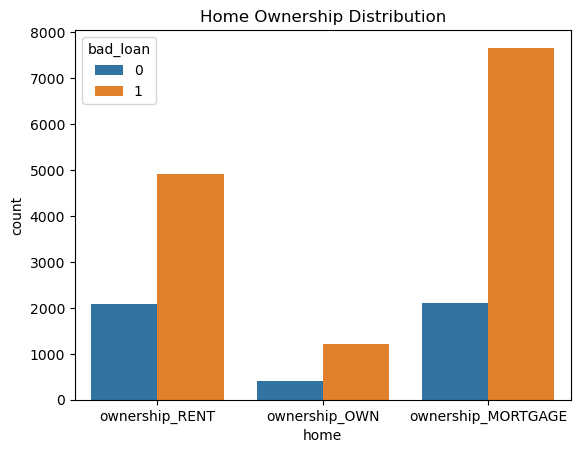

In [106]:
sns.countplot(x=df_joined_copied.home, hue=df_joined_copied.bad_loan);
plt.title('Home Ownership Distribution');

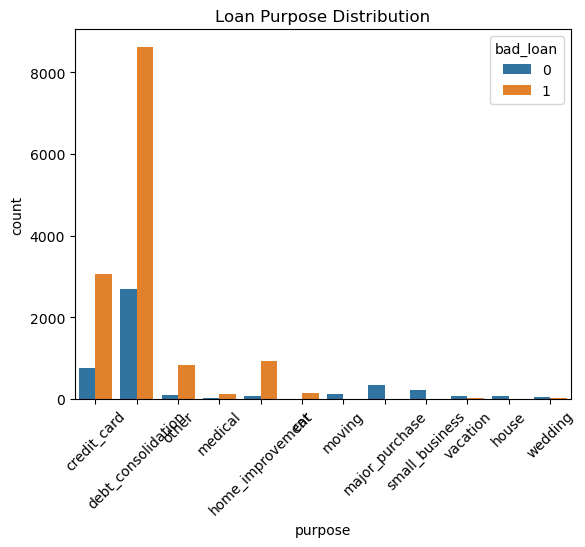

In [107]:
sns.countplot(x=df_joined_copied.purpose, hue=df_joined_copied.bad_loan);
plt.xticks(rotation=45)
plt.title('Loan Purpose Distribution');

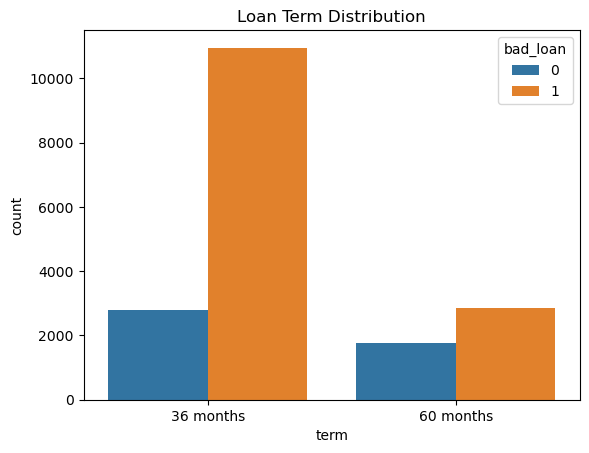

In [108]:
sns.countplot(x=df_joined_copied.term, hue=df_joined_copied.bad_loan);
plt.title('Loan Term Distribution');

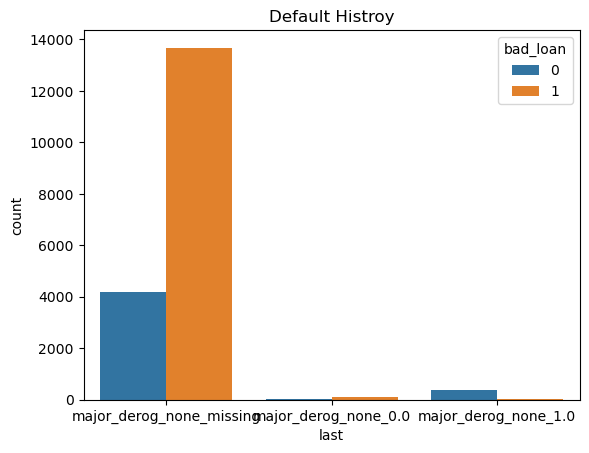

In [109]:
#Last _ delinq _ none - 1 when the debit has been in default at least once.
sns.countplot(x=df_joined_copied['last'], hue=df_joined_copied.bad_loan);
plt.title('Default Histroy');

#### Visualization of Continuous Features' Distributions

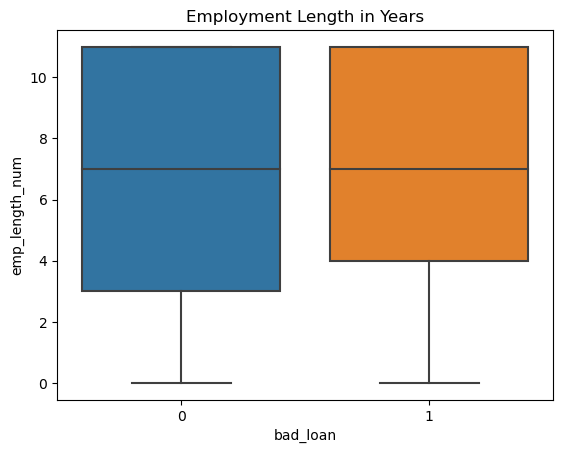

In [110]:
sns.boxplot(y='emp_length_num',
                x ='bad_loan',
                data=df_joined);
plt.title('Employment Length in Years')
plt.show()

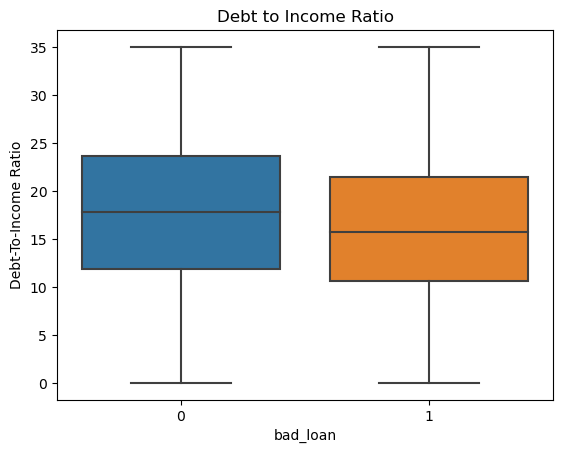

In [111]:
sns.boxplot(y='Debt-To-Income Ratio',
                x='bad_loan',
                data=df_joined);
plt.title('Debt to Income Ratio')
plt.show()

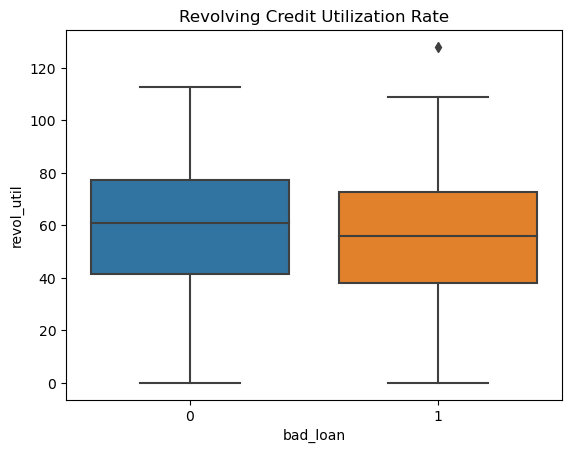

In [112]:
sns.boxplot(y='revol_util',
                x = 'bad_loan', 
                data=df_joined);
plt.title('Revolving Credit Utilization Rate')
plt.show()

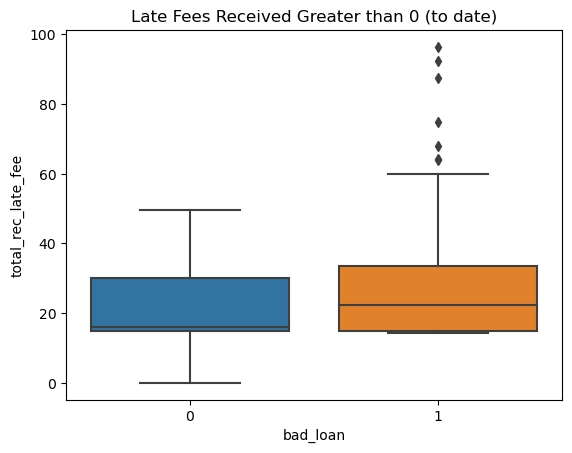

In [113]:
total_rec_late_fee_not0_df = df_joined[df_joined.total_rec_late_fee != 0]

sns.boxplot(y='total_rec_late_fee',
            x = 'bad_loan', 
            data=total_rec_late_fee_not0_df);
plt.title('Late Fees Received Greater than 0 (to date)');

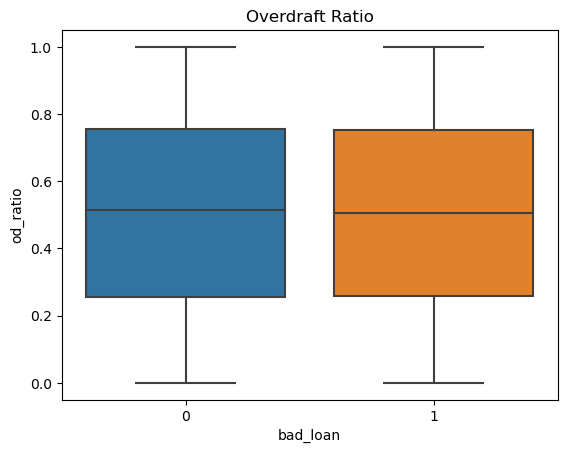

In [114]:
sns.boxplot(y='od_ratio',
                x = 'bad_loan', 
                data=df_joined);
plt.title('Overdraft Ratio')
plt.show()

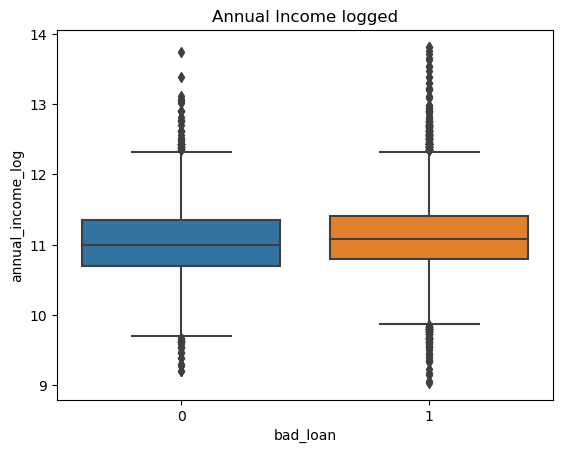

In [115]:
sns.boxplot(y='annual_income_log',
                x = 'bad_loan', 
                data=df_joined);
plt.title('Annual Income logged')
plt.show()